# Predicting employee attrition

### Nicola Croon, Elena Bolgiani

## 1. Introduction

### 1.1 Background:

Employee turnover has been identified as a key issue for organizations because of its adverse impact on work place productivity and long term growth strategies.

Attrition in human resources refers to the gradual loss of employees over time. In general, relatively high attrition is problematic for companies.
The key to success in an organization is the ability to attract and retain top talents. It is vital for the Human Resource (HR) Department to identify the factors that keep employees and those which prompt them to leave. HR professionals often assume a leadership role in designing company compensation programs, work culture and motivation systems that help the organization retain top employees.

### 1.2 Problem:

A major problem in high employee attrition is its cost to an organization. Job postings, hiring processes, paperwork and new hire training are some of the common expenses of losing employees and replacing them. Additionally, regular employee turnover prohibits your organization from increasing its collective knowledge base and experience over time. 

To solve this problem, organizations use machine learning techniques to predict employee turnover. Accurate predictions enable organizations to take action for retention or succession planning of employees.

## 2. Business context exploration and feature analysis

In [1]:
# import the necessary packages:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

r_seed = 1123
pd.set_option('display.max_columns', 100)

%matplotlib inline 
#necessary to plot inside the notebook

In [2]:
# This is a useful function to print a summary of the results of cross validation. We will use it later.
def print_cv(cv):
    print('\n'.join([str((x, y, z)) for (x, y, z) in zip(cv.cv_results_['params'], cv.cv_results_['mean_train_score'], cv.cv_results_['mean_test_score'])]))

In [4]:
# import csv
df_employees = pd.read_csv('EmployeeAttrition.csv')

### 2.1 Data analysis and cleaning:

In [5]:
# display the first 5 rows of the dataset:
df_employees.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,1318,12/31/2009 0:00,1/3/1954,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,1318,12/31/2010 0:00,1/3/1954,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE


In [6]:
# check the number of rows and columns of the dataset:
df_employees.shape

(49653, 18)

In [7]:
# show information only on numerical variables (with include = 'all' also on categorical variables (NaN))
df_employees.describe()

,EmployeeID,age,length_of_service,store_name,STATUS_YEAR
count,49653.000000,49653.000000,49653.000000,49653.000000,49653.000000
mean,4859.495740,42.077035,10.434596,27.297605,2010.612612
std,1826.571142,12.427257,6.325286,13.514134,2.845577
min,1318.000000,19.000000,0.000000,1.000000,2006.000000
25%,3360.000000,31.000000,5.000000,16.000000,2008.000000
50%,5031.000000,42.000000,10.000000,28.000000,2011.000000
75%,6335.000000,53.000000,15.000000,42.000000,2013.000000
max,8336.000000,65.000000,26.000000,46.000000,2015.000000


In [8]:
# show the names of the columns with the number of observations for each column
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49653 entries, 0 to 49652
Data columns (total 18 columns):
EmployeeID             49653 non-null int64
recorddate_key         49653 non-null object
birthdate_key          49653 non-null object
orighiredate_key       49653 non-null object
terminationdate_key    49653 non-null object
age                    49653 non-null int64
length_of_service      49653 non-null int64
city_name              49653 non-null object
department_name        49653 non-null object
job_title              49653 non-null object
store_name             49653 non-null int64
gender_short           49653 non-null object
gender_full            49653 non-null object
termreason_desc        49653 non-null object
termtype_desc          49653 non-null object
STATUS_YEAR            49653 non-null int64
STATUS                 49653 non-null object
BUSINESS_UNIT          49653 non-null object
dtypes: int64(5), object(13)
memory usage: 6.8+ MB


In [9]:
# check the data types 
df_employees.dtypes

EmployeeID              int64
recorddate_key         object
birthdate_key          object
orighiredate_key       object
terminationdate_key    object
age                     int64
length_of_service       int64
city_name              object
department_name        object
job_title              object
store_name              int64
gender_short           object
gender_full            object
termreason_desc        object
termtype_desc          object
STATUS_YEAR             int64
STATUS                 object
BUSINESS_UNIT          object
dtype: object

In [10]:
# Above we can see that some data types are wrong. 
# recorddate_key, birthdate_key, orighiredate_key, terminationdate_key, STATUS_YEAR are read as object instead of date 
# Similarly, EmployeeID and store_name are considered integer rather than strings.
# So, We read the dataset again changing the data types:

df_employees = pd.read_csv('EmployeeAttrition.csv',
                           parse_dates=['recorddate_key','birthdate_key','orighiredate_key','terminationdate_key','STATUS_YEAR'], 
                           dtype={'EmployeeID':str, 'store_name':str})
df_employees.dtypes

EmployeeID                     object
recorddate_key         datetime64[ns]
birthdate_key          datetime64[ns]
orighiredate_key       datetime64[ns]
terminationdate_key    datetime64[ns]
age                             int64
length_of_service               int64
city_name                      object
department_name                object
job_title                      object
store_name                     object
gender_short                   object
gender_full                    object
termreason_desc                object
termtype_desc                  object
STATUS_YEAR            datetime64[ns]
STATUS                         object
BUSINESS_UNIT                  object
dtype: object

In [11]:
# check the number of observations in the dataset
len(df_employees)

49653

In [12]:
# check how many unique EmployeeID there are
len(df_employees.EmployeeID.unique()) 

6284

In [13]:
# It doesn't make sense to have duplicated EmployeeID
# We have to keep only the last observation (the last recorddate_key)
df_employees= df_employees.sort_values('recorddate_key').drop_duplicates('EmployeeID',keep='last')
df_employees.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
48424,2304,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,Vernon,Meats,Meat Cutter,36,F,Female,Retirement,Voluntary,2006-01-01,TERMINATED,STORES
48812,4118,2006-01-01,1946-01-23,1997-07-31,2006-01-23,60,8,Vancouver,Meats,Meat Cutter,35,M,Male,Retirement,Voluntary,2006-01-01,TERMINATED,STORES
48423,2303,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,New Westminster,Meats,Meat Cutter,21,F,Female,Retirement,Voluntary,2006-01-01,TERMINATED,STORES
48811,4116,2006-01-01,1946-01-22,1997-07-30,2006-01-22,60,8,Richmond,Produce,Produce Clerk,29,M,Male,Retirement,Voluntary,2006-01-01,TERMINATED,STORES
48808,4110,2006-01-01,1946-01-16,1997-07-24,2006-01-16,60,8,Surrey,Produce,Produce Clerk,31,M,Male,Retirement,Voluntary,2006-01-01,TERMINATED,STORES


In [14]:
# let's check the length now:
len(df_employees) # ok! we have only unique EmployeeID

6284

In [15]:
# Let's focus on our target variable STATUS.
# STATUS has 2 possible outcomes: TERMINATED and ACTIVE
# We trasform STATUS from categorical to numerical 
# We substitute TERMINATED/ACTIVE with 0/1, using the method replace

df_employees['STATUS'].replace({'TERMINATED': 0, 'ACTIVE': 1}, inplace=True)
df_employees.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
48424,2304,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,Vernon,Meats,Meat Cutter,36,F,Female,Retirement,Voluntary,2006-01-01,0,STORES
48812,4118,2006-01-01,1946-01-23,1997-07-31,2006-01-23,60,8,Vancouver,Meats,Meat Cutter,35,M,Male,Retirement,Voluntary,2006-01-01,0,STORES
48423,2303,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,New Westminster,Meats,Meat Cutter,21,F,Female,Retirement,Voluntary,2006-01-01,0,STORES
48811,4116,2006-01-01,1946-01-22,1997-07-30,2006-01-22,60,8,Richmond,Produce,Produce Clerk,29,M,Male,Retirement,Voluntary,2006-01-01,0,STORES
48808,4110,2006-01-01,1946-01-16,1997-07-24,2006-01-16,60,8,Surrey,Produce,Produce Clerk,31,M,Male,Retirement,Voluntary,2006-01-01,0,STORES


In [16]:
# let's check the percentage of active employees and of ex-employees:
df_employees['STATUS'].mean() 

0.7644812221514958

In [17]:
# Count how many employees are active or not:
df_employees.groupby('STATUS')[['EmployeeID']].count()

,EmployeeID
STATUS,
0,1480
1,4804


In [18]:
# Find the percentage of active employees and ex-employees over the total:
df_employees.groupby('STATUS')[['EmployeeID']].count() / df_employees.shape[0]

,EmployeeID
STATUS,
0,0.235519
1,0.764481


Now we check how many observations there are for each variable.
From this analysis we can see if there are errors (values). For example if there is a city_name = 1. That's an error. 
If there are errors, we can substitute them with the correct value.

In [19]:
# how many obs per city name:
employees_per_city = df_employees['city_name'].value_counts() 
employees_per_city
# no errors
# there are enough information (not drop)

Vancouver           1392
Victoria             624
Nanaimo              481
New Westminster      403
Kelowna              305
Kamloops             267
Prince George        264
Burnaby              258
Cranbrook            219
Surrey               197
Richmond             176
Terrace              160
Chilliwack           147
Trail                121
Langley              118
Vernon               109
Squamish             101
Quesnel               94
Abbotsford            90
Fort St John          89
West Vancouver        84
North Vancouver       81
Williams Lake         72
Port Coquitlam        67
Aldergrove            65
Fort Nelson           47
New Westminister      44
Nelson                39
Grand Forks           33
White Rock            28
Haney                 24
Princeton             19
Bella Bella           18
Dawson Creek          18
Pitt Meadows           9
Ocean Falls            7
Cortes Island          6
Valemount              5
Dease Lake             2
Blue River             1


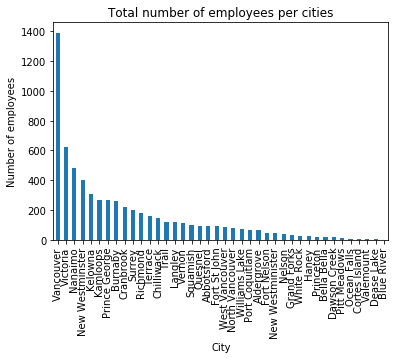

In [20]:
# visualize employees' distribution per city in a bar graph:
employees_per_city.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Number of employees')
plt.title("Total number of employees per cities")
plt.show()

In [21]:
# how many obs per department name: 
employees_per_department = df_employees['department_name'].value_counts() 
employees_per_department
# no errors
# there are enough information (not drop)

Meats                     1252
Customer Service          1190
Produce                   1060
Dairy                     1033
Bakery                     898
Processed Foods            736
Store Management            35
Executive                   10
HR Technology                9
Recruitment                  9
Employee Records             6
Labor Relations              6
Accounting                   6
Training                     5
Information Technology       5
Accounts Receiveable         5
Investment                   4
Compensation                 4
Accounts Payable             4
Audit                        4
Legal                        3
Name: department_name, dtype: int64

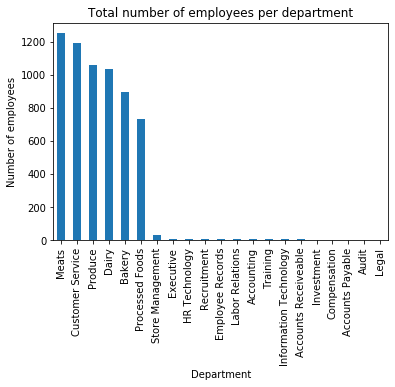

In [22]:
# visualize employees' distribution per department in a bar graph:
employees_per_department.plot(kind='bar')
plt.xlabel('Department')
plt.ylabel('Number of employees')
plt.title("Total number of employees per department")
plt.show()

In [23]:
# how many obs per job title: 
employees_per_jobtitle= df_employees['job_title'].value_counts() 
employees_per_jobtitle
# no errors
# there are enough information (not drop)

Meat Cutter                        1218
Cashier                            1158
Dairy Person                       1032
Produce Clerk                      1027
Baker                               865
Shelf Stocker                       704
Store Manager                        35
Meats Manager                        34
Produce Manager                      33
Bakery Manager                       33
Customer Service Manager             32
Processed Foods Manager              32
Recruiter                             8
HRIS Analyst                          8
Benefits Admin                        5
Labor Relations Analyst               5
Accounting Clerk                      5
Systems Analyst                       5
Trainer                               4
Accounts Receiveable Clerk            4
Investment Analyst                    3
Accounts Payable Clerk                3
Compensation Analyst                  3
Corporate Lawyer                      3
Auditor                               3


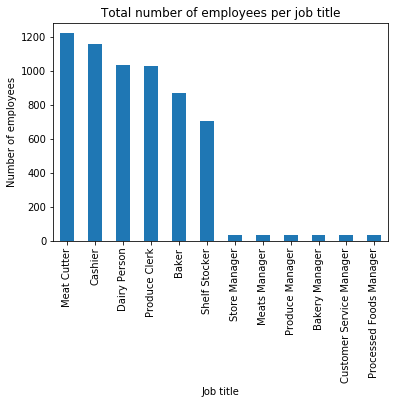

In [24]:
# visualize employees' distribution per job title in a bar graph:
# It doesn't make sense to plot the job title with less than 10 employees
# We plot just the first 12 values (>10)
employees_per_jobtitle2 = employees_per_jobtitle.head(12)

employees_per_jobtitle2.plot(kind='bar')
plt.xlabel('Job title')
plt.ylabel('Number of employees')
plt.title("Total number of employees per job title")
plt.show()

In [25]:
# how many obs per store name: 
employees_per_storename = df_employees['store_name'].value_counts() 
employees_per_storename
# no errors
# there are enough information (not drop)

46    522
18    481
21    403
42    392
43    311
16    305
44    284
15    267
26    264
5     258
35    221
8     219
31    197
41    178
29    176
32    160
6     147
33    121
17    118
36    109
37    102
30    101
28     94
1      90
12     89
38     84
22     81
40     72
25     67
2      65
11     47
20     44
19     39
13     33
39     28
14     24
27     19
3      18
9      18
24      9
23      7
45      6
7       6
34      5
10      2
4       1
Name: store_name, dtype: int64

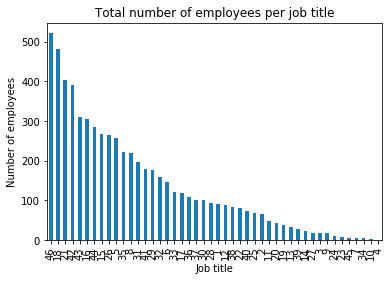

In [26]:
# visualize employees' distribution per store name in a bar graph:
employees_per_storename.plot(kind='bar')
plt.xlabel('Job title')
plt.ylabel('Number of employees')
plt.title("Total number of employees per job title")
plt.show()

In [27]:
# how many obs per gender:
df_employees['gender_full'].value_counts() 
# no errors
# there are enough information (not drop)

Female    3278
Male      3006
Name: gender_full, dtype: int64

In [28]:
# find percentage of male and female
gender_percentage = df_employees['gender_full'].value_counts() / df_employees.shape[0]
gender_percentage

Female    0.521642
Male      0.478358
Name: gender_full, dtype: float64

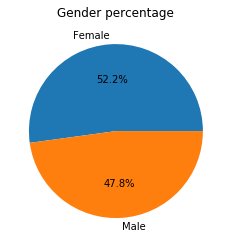

In [29]:
# visualize male and female percentage in a pie chart:
plt.pie(gender_percentage, labels = gender_percentage.index, autopct='%.1f%%')
plt.title('Gender percentage')
plt.show()

In [30]:
# how many obs per termreason_desc:
termreason_occurences = df_employees['termreason_desc'].value_counts() 
termreason_occurences
# no errors
# But this variable is almost constant. 
# We should drop it during the feature analysis because it is not useful for the analysis. 

Not Applicable    4804
Retirement         883
Resignaton         382
Layoff             215
Name: termreason_desc, dtype: int64

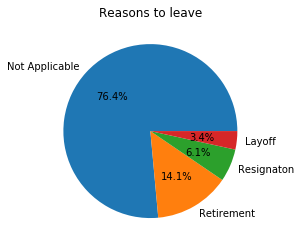

In [31]:
# visualize the reasons to leave in a pie chart:
plt.pie(termreason_occurences, labels = termreason_occurences.index, autopct='%.1f%%')
plt.title('Reasons to leave')
plt.show()

In [32]:
# how many obs per termtype_desc:
termtype_occurences = df_employees['termtype_desc'].value_counts() 
termtype_occurences
# no errors
# there are enough information (not drop)

Not Applicable    4804
Voluntary         1265
Involuntary        215
Name: termtype_desc, dtype: int64

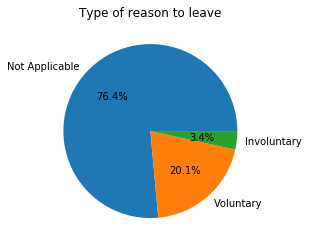

In [33]:
# visualize the types of reasons to leave in a pie chart:
plt.pie(termtype_occurences, labels = termtype_occurences.index, autopct='%.1f%%')
plt.title('Type of reason to leave')
plt.show()

In [34]:
# how many obs per business unit:
business_unit = df_employees['BUSINESS_UNIT'].value_counts() 
business_unit
# no errors
# But this variable is almost constant. 
# We should drop it during the feature analysis because it is not useful for the analysis. 

STORES        6204
HEADOFFICE      80
Name: BUSINESS_UNIT, dtype: int64

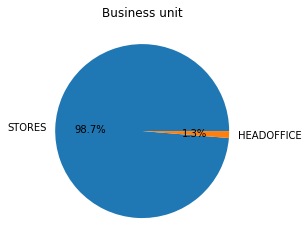

In [35]:
# visualize the business units in a pie chart:
plt.pie(business_unit, labels = business_unit.index, autopct='%.1f%%')
plt.title('Business unit')
plt.show()

It is very important to check where there are missing values and replace them.

In [36]:
# I calculate the percentage of missing values for each variable:
df_employees.isna().sum()/df_employees.shape[0]
# I can see that there are not null values, so there is no need to replace.

EmployeeID             0.0
recorddate_key         0.0
birthdate_key          0.0
orighiredate_key       0.0
terminationdate_key    0.0
age                    0.0
length_of_service      0.0
city_name              0.0
department_name        0.0
job_title              0.0
store_name             0.0
gender_short           0.0
gender_full            0.0
termreason_desc        0.0
termtype_desc          0.0
STATUS_YEAR            0.0
STATUS                 0.0
BUSINESS_UNIT          0.0
dtype: float64

We have checked all the categorical variables. Now we check the integers (age and length of service) and the dates (recorddate_key, birthdate_key, orighiredate_key, terminationdate_key, STATUS_YEAR).

Let's check for outliers with some graphs:

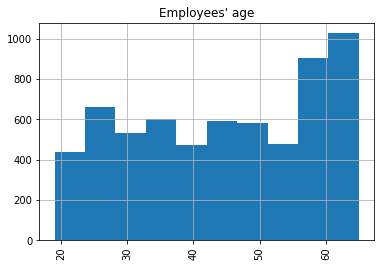

In [37]:
# visualize the age of the employees with a histogram:
plt.figure()
df_employees['age'].hist()
plt.xticks(rotation='vertical')
plt.title("Employees' age")
plt.show()
# no outlier

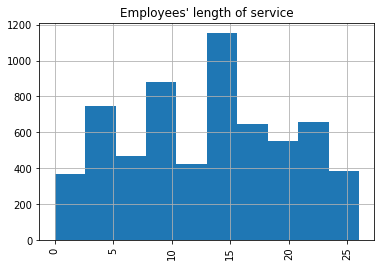

In [38]:
# visualize the length of the service of the employees with a histogram:
plt.figure()
df_employees['length_of_service'].hist()
plt.xticks(rotation='vertical')
plt.title("Employees' length of service")
plt.show()
# no outlier

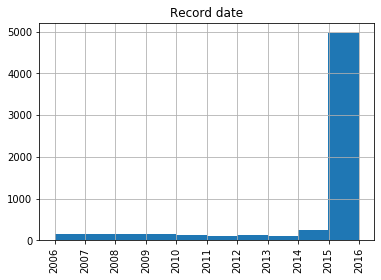

In [39]:
# visualize the record date with a histogram:
plt.figure()
df_employees['recorddate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Record date")
plt.show()
# no outlier

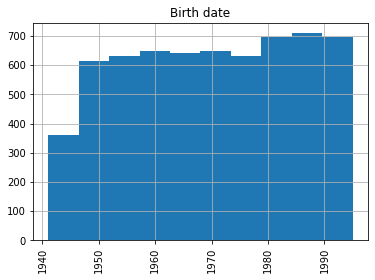

In [40]:
# visualize the birth date with a histogram:
plt.figure()
df_employees['birthdate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Birth date")
plt.show()
# no outlier

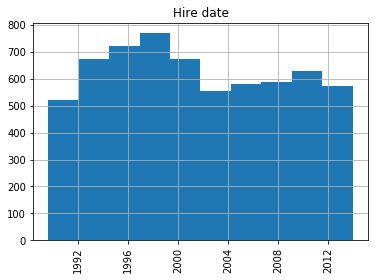

In [41]:
# visualize the hire date with a histogram:
plt.figure()
df_employees['orighiredate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Hire date")
plt.show()
# no outlier

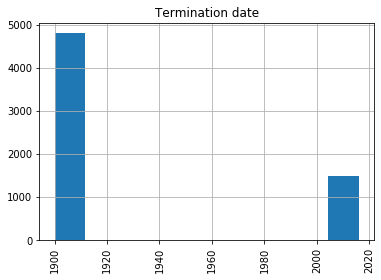

In [42]:
# visualize the termination date with histogram:
plt.figure()
df_employees['terminationdate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Termination date")
plt.show()

In [43]:
# We are not sure but it is weird to have a terminationdate = 1900-01-01.
# We think that this is a mistake. 
# So, we identify it as a missing value (NaN):
df_employees.loc[df_employees['terminationdate_key'] == pd.to_datetime('1900-01-01'), 'terminationdate_key'] = np.nan

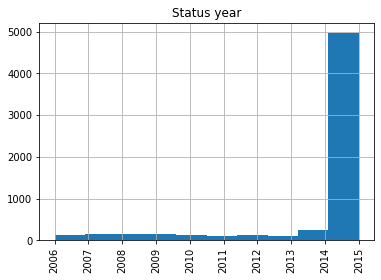

In [44]:
# visualize the status year with histogram:
plt.figure()
df_employees['STATUS_YEAR'].hist()
plt.xticks(rotation='vertical')
plt.title("Status year")
plt.show()
# no outlier

In [45]:
# After this first analysis, we can drop some columns. 
# We get rid of the index and the date time objects:
df_employees.drop(['EmployeeID', 'recorddate_key', 'birthdate_key','orighiredate_key','terminationdate_key','STATUS_YEAR'], 1, inplace=True) 

df_employees.head()

,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS,BUSINESS_UNIT
48424,65,13,Vernon,Meats,Meat Cutter,36,F,Female,Retirement,Voluntary,0,STORES
48812,60,8,Vancouver,Meats,Meat Cutter,35,M,Male,Retirement,Voluntary,0,STORES
48423,65,13,New Westminster,Meats,Meat Cutter,21,F,Female,Retirement,Voluntary,0,STORES
48811,60,8,Richmond,Produce,Produce Clerk,29,M,Male,Retirement,Voluntary,0,STORES
48808,60,8,Surrey,Produce,Produce Clerk,31,M,Male,Retirement,Voluntary,0,STORES


We have concluded our first exploratory data analysis. We have analyzed both numerical and categorical variables and now we have a first idea of the variables which can be significant for our models. We will explore them deeply in the feature analysis phase.

### 2.2 Features analysis

In [46]:
# We have already analyze this variable in the previous analysis.
# We can see that almost everything is from category "STORES"
# This variable is not useful for prediction because almost all the observations are from one category.
df_employees['BUSINESS_UNIT'].value_counts() # I can drop the column, almost constant

STORES        6204
HEADOFFICE      80
Name: BUSINESS_UNIT, dtype: int64

In [47]:
# Same reasoning as before:
df_employees['termreason_desc'].value_counts() # I can drop the column, almost constant

Not Applicable    4804
Retirement         883
Resignaton         382
Layoff             215
Name: termreason_desc, dtype: int64

In [48]:
# We can be even more confident in dropping termreason_desc by doing this analysis:
df_employees.groupby(['termtype_desc', 'termreason_desc']).count()
# We can see that termreason_desc is a sub-category of termtype_desc. So, it is not relevant for our analysis. 

age  length_of_service  city_name  \
termtype_desc  termreason_desc                                       
Involuntary    Layoff            215                215        215   
Not Applicable Not Applicable   4804               4804       4804   
Voluntary      Resignaton        382                382        382   
               Retirement        883                883        883   

                                department_name  job_title  store_name  \
termtype_desc  termreason_desc                                           
Involuntary    Layoff                       215        215         215   
Not Applicable Not Applicable              4804       4804        4804   
Voluntary      Resignaton                   382        382         382   
               Retirement                   883        883         883   

                                gender_short  gender_full  STATUS  \
termtype_desc  termreason_desc                                      
Involuntary    Layoff                    215          215     215   
Not Applicable Not Applicable           4804         4804    4804   
Voluntary      Resignaton                382          382     382   
               Retirement                883          883     883   

                                BUSINESS_UNIT  
termtype_desc  termreason_desc                 
Involuntary    Layoff                     215  
Not Applicable Not Applicable            4804  
Voluntary      Resignaton                 382  
               Retirement                 883

In [49]:
# Let's check termtype_desc: 
df_employees.groupby(['STATUS', 'termtype_desc']).count()
# termtype_desc is a proxy of the target. It is a sub-category of the target.
# We have to drop this variable. The analysis could be conducted on STATUS or termtype_desc but not on both of them.
# Otherwise, it would become a multiclass problem. 

age  length_of_service  city_name  department_name  \
STATUS termtype_desc                                                         
0      Involuntary      215                215        215              215   
       Voluntary       1265               1265       1265             1265   
1      Not Applicable  4804               4804       4804             4804   

                       job_title  store_name  gender_short  gender_full  \
STATUS termtype_desc                                                      
0      Involuntary           215         215           215          215   
       Voluntary            1265        1265          1265         1265   
1      Not Applicable       4804        4804          4804         4804   

                       termreason_desc  BUSINESS_UNIT  
STATUS termtype_desc                                   
0      Involuntary                 215            215  
       Voluntary                  1265           1265  
1      Not Applicable             4804           4804

In [50]:
# I drop the columns which are not useful for our analysis: 
# termreason_desc, BUSINESS_UNIT and termtype_desc for the reasons explained before.
# gender_short because it is redundant (we already have gender_full)
df_employees.drop(['termreason_desc', 'BUSINESS_UNIT','termtype_desc','gender_short'], 1, inplace=True) 
df_employees.head()

,age,length_of_service,city_name,department_name,job_title,store_name,gender_full,STATUS
48424,65,13,Vernon,Meats,Meat Cutter,36,Female,0
48812,60,8,Vancouver,Meats,Meat Cutter,35,Male,0
48423,65,13,New Westminster,Meats,Meat Cutter,21,Female,0
48811,60,8,Richmond,Produce,Produce Clerk,29,Male,0
48808,60,8,Surrey,Produce,Produce Clerk,31,Male,0


## 3. Exploratory data analysis:

### 3.1 Relationship between STATUS and age:

In [51]:
# to analyze better the relationship between STATUS and age, we create a new variable: age_range
bins= [18,30,40,50,60,70] 
labels = ['18-30','31-40','41-50','51-60','61-70']
df_employees['age_range'] = pd.cut(df_employees['age'], bins=bins, labels=labels, right=False)
df_employees.sample(5) # let's check if the variable works by calling a sample of 5 rows

,age,length_of_service,city_name,department_name,job_title,store_name,gender_full,STATUS,age_range
19483,50,17,Victoria,Customer Service,Cashier,46,Female,1,51-60
47042,24,3,Vancouver,Processed Foods,Shelf Stocker,44,Male,1,18-30
48743,65,13,Victoria,Produce,Produce Clerk,37,Female,0,61-70
48756,44,10,Chilliwack,Produce,Produce Clerk,6,Male,0,41-50
45488,26,5,Vancouver,Bakery,Baker,44,Male,1,18-30


In [52]:
df_employees['age_range'].value_counts()

61-70    1429
31-40    1249
51-60    1232
18-30    1225
41-50    1149
Name: age_range, dtype: int64

In [53]:
# For simplicity, we created 2 new datasets: 
# df_active contains the data of the active employees
# df_nonactive contains the data of the ex-employees

df_active=df_employees[df_employees['STATUS']==1]
df_notactive=df_employees[df_employees['STATUS']==0]

print('The number of active employees is: ',len(df_active))
print('The number of ex-employees is: ',len(df_notactive))

The number of active employees is:  4804
The number of ex-employees is:  1480


In [54]:
# Relationship between active employees and age range:
active_age = df_active['age_range'].value_counts().to_frame().reset_index()
active_age.rename(columns={'index':'age','age_range':'count'},inplace=True)
num_active=len(df_active)
active_age['percentage']= active_age['count']/num_active
active_age

,age,count,percentage
0,51-60,1170,0.243547
1,41-50,1077,0.224188
2,31-40,1064,0.221482
3,18-30,977,0.203372
4,61-70,516,0.107410


In [55]:
# Relationship between ex-employees and age range:
ex_age = df_notactive['age_range'].value_counts().to_frame().reset_index()
ex_age.rename(columns={'index':'age','age_range':'count'},inplace=True)
num_notactive=len(df_notactive)
ex_age['percentage'] = ex_age['count']/num_notactive
ex_age

,age,count,percentage
0,61-70,913,0.616892
1,18-30,248,0.167568
2,31-40,185,0.125000
3,41-50,72,0.048649
4,51-60,62,0.041892


In [56]:
# Relationsip between all employees and age range:
all_age = df_employees['age_range'].value_counts().to_frame().reset_index()
all_age.rename(columns={'index':'age','age_range':'count'},inplace=True)
num_all = len(df_employees)
all_age['percentage'] = all_age['count']/num_all
all_age

,age,count,percentage
0,61-70,1429,0.227403
1,31-40,1249,0.198759
2,51-60,1232,0.196053
3,18-30,1225,0.194940
4,41-50,1149,0.182845


From this analysis, we can see that there isn't a more common age range in active employees. They are distributed well, except from older active employees which are less. The employees who leave the company are mainly between 61-70 years old. The main reason could be retirement. In conclusion, considering both active and ex-employees, we can say that there are employees of every age. 

### 3.2 Relationship between STATUS and length of service:

In [57]:
# Relationship between active employees and length of service:
active_lof=df_active['length_of_service'].value_counts().to_frame().reset_index()
active_lof.rename(columns={'index':'length of service','length_of_service':'count'},inplace=True)
num_active = len(df_active)
active_lof['percentage']= active_lof['count']/num_active
active_lof.head()

,length of service,count,percentage
0,20,237,0.049334
1,10,237,0.049334
2,15,229,0.047669
3,3,223,0.046420
4,18,219,0.045587


In [58]:
# Relationship between ex-employees and length of service:
ex_lof = df_notactive['length_of_service'].value_counts().to_frame().reset_index()
ex_lof.rename(columns={'index':'length of service','length_of_service':'count'},inplace=True)
num_notactive = len(df_notactive)
ex_lof['percentage'] = ex_lof['count']/num_notactive
ex_lof.head()

,length of service,count,percentage
0,13,483,0.326351
1,8,218,0.147297
2,1,135,0.091216
3,24,79,0.053378
4,19,76,0.051351


In [59]:
# Relationship between all employees and length of service:
all_lof = df_employees['length_of_service'].value_counts().to_frame().reset_index()
all_lof.rename(columns={'index':'length of service','length_of_service':'count'},inplace=True)
num_all = len(df_employees)
all_lof['percentage'] = all_lof['count']/num_all
all_lof.head()

,length of service,count,percentage
0,13,700,0.111394
1,8,395,0.062858
2,19,280,0.044558
3,20,273,0.043444
4,5,267,0.042489


From this analysis, we can see that we have more active employees with 10-20 years of service. However, the length of service of active exmployees is very similar. The employees who leave the company have generally 13 years of service. This is not unexpected. Employees with longer service are usually older and we have already seen that older employees are more likely to leave. In conclusion, on average, the employees have 13 years of service.

### 3.3 Relationship between STATUS and city name:

In [60]:
# Relationship between active employees and city:
active_city = df_active['city_name'].value_counts().to_frame().reset_index()
active_city.rename(columns={'index':'city','city_name':'count'},inplace=True)
num_active=len(df_active)
active_city['percentage'] = active_city['count']/num_active
active_city.head()

,city,count,percentage
0,Vancouver,1097,0.228351
1,Victoria,474,0.098668
2,Nanaimo,399,0.083056
3,New Westminster,333,0.069317
4,Kelowna,248,0.051624


In [61]:
# Relationship between ex-employees and city:
ex_city = df_notactive['city_name'].value_counts().to_frame().reset_index()
ex_city.rename(columns={'index':'city','city_name':'count'},inplace=True)
num_notactive = len(df_notactive)
ex_city['percentage'] = ex_city['count']/num_notactive
ex_city.head()

,city,count,percentage
0,Vancouver,295,0.199324
1,Victoria,150,0.101351
2,Nanaimo,82,0.055405
3,New Westminster,70,0.047297
4,Kamloops,61,0.041216


In [62]:
# Relationship between all employees and city:
all_city = df_employees['city_name'].value_counts().to_frame().reset_index()
all_city.rename(columns={'index':'city','city_name':'count'},inplace=True)
num_all = len(df_employees)
all_city['percentage'] = all_city['count']/num_all
all_city.head()

,city,count,percentage
0,Vancouver,1392,0.221515
1,Victoria,624,0.099300
2,Nanaimo,481,0.076544
3,New Westminster,403,0.064131
4,Kelowna,305,0.048536


This analysis is not that useful. We can see that the employees are mainly from the city of Vancouver. So, the greater number of employees who are active or non-active is from that city too. 

Despite the analysis is not that useful, for simple curiosity we wanted to graphically visualize where the employees are located on a map, just to give us a general idea and not only deal with tables and data. 

To do so we used the package called folium and the Foursquare API in order to get the geographical coordinates of each city. Unfortunately, we do have some misclassification on the map because the Foursquare API geolocalizes some cities in England or France or Australia, but they are only few observations.

In [63]:
locations = df_employees[['city_name']]

In [64]:
data = pd.DataFrame(locations['city_name'].value_counts().reset_index())
data.rename(columns={'index':'city','city_name':'count'},inplace=True)

In [69]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [70]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("Canada")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


Canada
(61.0666922, -107.9917071)
{'place_id': 235707734, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1428125, 'boundingbox': ['41.6765556', '83.3362128', '-141.00275', '-52.3231981'], 'lat': '61.0666922', 'lon': '-107.9917071', 'display_name': 'Canada', 'class': 'boundary', 'type': 'administrative', 'importance': 0.9761259109654082, 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png'}


In [71]:
CLIENT_ID = 'DV5DFTF4YGRFQD51YWF3OP10AEYMOJJX1MGWV0MLBEQUK0MC' # your Foursquare ID
CLIENT_SECRET = 'XJQ0Z2BDLT4Y2N1SRHYLFDKDRILBV3RRWMO5HWKTZG2RLXKF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DV5DFTF4YGRFQD51YWF3OP10AEYMOJJX1MGWV0MLBEQUK0MC
CLIENT_SECRET:XJQ0Z2BDLT4Y2N1SRHYLFDKDRILBV3RRWMO5HWKTZG2RLXKF


In [72]:
from geopy.extra.rate_limiter import RateLimiter
# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(geolocator.geocode,min_delay_seconds=1)
# 2- - create location column
data['location'] = data['city'].apply(geocode)

In [73]:
# 3 - create longitude, latitude and altitude from location column (returns tuple)
data['point'] = data['location'].apply(lambda loc: tuple(loc.point) if loc else None)
data.head()

,city,count,location,point
0,Vancouver,1392,"(Vancouver, Metro Vancouver Regional District,...","(49.2608724, -123.1139529, 0.0)"
1,Victoria,624,"(Victoria, Australia, (-36.5986096, 144.6780052))","(-36.5986096, 144.6780052, 0.0)"
2,Nanaimo,481,"(Nanaimo, Regional District of Nanaimo, Britis...","(49.1637594, -123.9379719, 0.0)"
3,New Westminster,403,"(New Westminster, Metro Vancouver Regional Dis...","(49.205728, -122.9108651, 0.0)"
4,Kelowna,305,"(Kelowna, Regional District of Central Okanaga...","(49.889326, -119.498291, 0.0)"


In [74]:
# 4 - split point column into latitude, longitude and altitude columns
data[['latitude', 'longitude', 'altitude']] = pd.DataFrame(data['point'].tolist(),index=data.index)
data.head()

,city,count,location,point,latitude,longitude,altitude
0,Vancouver,1392,"(Vancouver, Metro Vancouver Regional District,...","(49.2608724, -123.1139529, 0.0)",49.260872,-123.113953,0.0
1,Victoria,624,"(Victoria, Australia, (-36.5986096, 144.6780052))","(-36.5986096, 144.6780052, 0.0)",-36.598610,144.678005,0.0
2,Nanaimo,481,"(Nanaimo, Regional District of Nanaimo, Britis...","(49.1637594, -123.9379719, 0.0)",49.163759,-123.937972,0.0
3,New Westminster,403,"(New Westminster, Metro Vancouver Regional Dis...","(49.205728, -122.9108651, 0.0)",49.205728,-122.910865,0.0
4,Kelowna,305,"(Kelowna, Regional District of Central Okanaga...","(49.889326, -119.498291, 0.0)",49.889326,-119.498291,0.0


In [75]:
data = data.drop(['location','point','altitude'],axis=1)

In [77]:
data.to_csv('locations_lat_long')
data = pd.read_csv('locations_lat_long')

In [78]:
data.drop(columns='Unnamed: 0', inplace=True)

In [79]:
data.head()

,city,count,latitude,longitude
0,Vancouver,1392,49.260872,-123.113953
1,Victoria,624,-36.598610,144.678005
2,Nanaimo,481,49.163759,-123.937972
3,New Westminster,403,49.205728,-122.910865
4,Kelowna,305,49.889326,-119.498291


In [80]:
pip install folium 

     |████████████████████████████████| 92kB 758kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [303]:
# create map using latitude and longitude values
import folium # map rendering library
import geopy
latitude = location.latitude
longitude = location.longitude

map = folium.Map(location=[latitude, longitude], zoom_start=3)
# add markers to map
for lat, lng, label in zip(data['latitude'], data['longitude'], data['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,).add_to(map)  
    
map

And here we are, this is geographical representation of where the employees are located!

### 3.4 Relationship between STATUS and department name:

In [82]:
# Relationship between active employees and department name:
active_department_name = df_active['department_name'].value_counts().to_frame().reset_index()
active_department_name.rename(columns={'index':'department name','department_name':'count'},inplace=True)
num_active=len(df_active)
active_department_name['percentage'] = active_department_name['count']/num_active
active_department_name.head()

,department name,count,percentage
0,Customer Service,929,0.193381
1,Meats,876,0.182348
2,Dairy,843,0.175479
3,Bakery,786,0.163614
4,Produce,707,0.147169


In [83]:
# Relationship between ex-employees and department name:
ex_department_name = df_notactive['department_name'].value_counts().to_frame().reset_index()
ex_department_name.rename(columns={'index':'department name','department_name':'count'},inplace=True)
num_notactive = len(df_notactive)
ex_department_name['percentage'] = ex_department_name['count']/num_notactive
ex_department_name.head()

,department name,count,percentage
0,Meats,376,0.254054
1,Produce,353,0.238514
2,Customer Service,261,0.176351
3,Dairy,190,0.128378
4,Bakery,112,0.075676


In [84]:
# Relationship between all employees and department name:
all_department_name = df_employees['department_name'].value_counts().to_frame().reset_index()
all_department_name.rename(columns={'index':'department name','department_name':'count'},inplace=True)
num_all = len(df_employees)
all_department_name['percentage'] = all_department_name['count']/num_all
all_department_name.head()

,department name,count,percentage
0,Meats,1252,0.199236
1,Customer Service,1190,0.189370
2,Produce,1060,0.168682
3,Dairy,1033,0.164386
4,Bakery,898,0.142903


From this analysis, we can see that the active employees are mainly from the Customer service department. The employees who leave the most are from the Meats department. In general, the department with more employees is the Meats one.

### 3.5 Relationship between STATUS and job title:

In [85]:
# Relationship between active employees and job title:
active_job_title = df_active['job_title'].value_counts().to_frame().reset_index()
active_job_title.rename(columns={'index':'job title','job_title':'count'},inplace=True)
num_active=len(df_active)
active_job_title['percentage'] = active_job_title['count']/num_active
active_job_title.head()

,job title,count,percentage
0,Cashier,911,0.189634
1,Meat Cutter,865,0.180058
2,Dairy Person,843,0.175479
3,Baker,774,0.161116
4,Produce Clerk,695,0.144671


In [86]:
# Relationship between ex-employees and job title:
ex_job_title = df_notactive['job_title'].value_counts().to_frame().reset_index()
ex_job_title.rename(columns={'index':'job title','job_title':'count'},inplace=True)
num_notactive = len(df_notactive)
ex_job_title['percentage'] = ex_job_title['count']/num_notactive
ex_job_title.head()

,job title,count,percentage
0,Meat Cutter,353,0.238514
1,Produce Clerk,332,0.224324
2,Cashier,247,0.166892
3,Dairy Person,189,0.127703
4,Baker,91,0.061486


In [87]:
# Relationship between all employees and job title:
all_job_title = df_employees['job_title'].value_counts().to_frame().reset_index()
all_job_title.rename(columns={'index':'job title','job_title':'count'},inplace=True)
num_all = len(df_employees)
all_job_title['percentage'] = all_job_title['count']/num_all
all_job_title.head()

,job title,count,percentage
0,Meat Cutter,1218,0.193826
1,Cashier,1158,0.184278
2,Dairy Person,1032,0.164227
3,Produce Clerk,1027,0.163431
4,Baker,865,0.137651


This analysis shows us that most of the active employees are cashiers, while most of the ex-employees are Meat Cutters. In general, most of the employees are Meat Cutters.

### 3.6 Relationship between STATUS and store name:

In [88]:
# Relationship between active employees and store name:
active_store = df_active['store_name'].value_counts().to_frame().reset_index()
active_store.rename(columns={'index':'store','store_name':'count'},inplace=True)
num_active = len(df_active)
active_store['percentage'] = active_store['count']/num_active
active_store.head()

,store,count,percentage
0,46,473,0.098460
1,18,399,0.083056
2,42,370,0.077019
3,21,333,0.069317
4,43,287,0.059742


In [89]:
# Relationship between ex-employees and store name:
ex_store = df_notactive['store_name'].value_counts().to_frame().reset_index()
ex_store.rename(columns={'index':'store','store_name':'count'},inplace=True)
num_notactive = len(df_notactive)
ex_store['percentage'] = ex_store['count']/num_notactive
ex_store.head()

,store,count,percentage
0,35,206,0.139189
1,37,101,0.068243
2,18,82,0.055405
3,21,70,0.047297
4,15,61,0.041216


In [90]:
# Relationship between all employees and store name:
all_store = df_employees['store_name'].value_counts().to_frame().reset_index()
all_store.rename(columns={'index':'store','store_name':'count'},inplace=True)
num_all = len(df_employees)
all_store['percentage'] = all_store['count']/num_all
all_store.head()

,store,count,percentage
0,46,522,0.083068
1,18,481,0.076544
2,21,403,0.064131
3,42,392,0.062381
4,43,311,0.049491


From this analysis, we can see the active employees are mainly from store 46. The employees who leave the most are from the store number 35. Finally, the store with more employees is number 46.

### 3.7 Relationship between STATUS and gender:

In [91]:
# Relationship between active employees and gender:
active_gender = df_active['gender_full'].value_counts().to_frame().reset_index()
active_gender.rename(columns={'index':'gender','gender_full':'count'},inplace=True)
num_active=len(df_active)
active_gender['percentage'] = active_gender['count']/num_active
active_gender

,gender,count,percentage
0,Male,2436,0.507077
1,Female,2368,0.492923


In [92]:
# Relationship between ex-employees and gender:
ex_gender = df_notactive['gender_full'].value_counts().to_frame().reset_index()
ex_gender.rename(columns={'index':'gender','gender_full':'count'},inplace=True)
num_notactive = len(df_notactive)
ex_gender['percentage'] = ex_gender['count']/num_notactive
ex_gender

,gender,count,percentage
0,Female,910,0.614865
1,Male,570,0.385135


In [93]:
# Relationship between all employees and gender:
all_gender = df_employees['gender_full'].value_counts().to_frame().reset_index()
all_gender.rename(columns={'index':'gender','gender_full':'count'},inplace=True)
num_all = len(df_employees)
all_gender['percentage'] = all_gender['count']/num_all
all_gender

,gender,count,percentage
0,Female,3278,0.521642
1,Male,3006,0.478358


From this analysis, we can see that there isn't a significant different between males and females as active employees. However, there is a significant difference in ex-employees. In fact, women leave more than men. 

In [94]:
# Because it is not useful to create machine learning models, I remove the variable age_range.
# We created this variable just for the exploratory data analysis. 

df_employees.drop('age_range', 1, inplace=True) 
df_employees.head()

,age,length_of_service,city_name,department_name,job_title,store_name,gender_full,STATUS
48424,65,13,Vernon,Meats,Meat Cutter,36,Female,0
48812,60,8,Vancouver,Meats,Meat Cutter,35,Male,0
48423,65,13,New Westminster,Meats,Meat Cutter,21,Female,0
48811,60,8,Richmond,Produce,Produce Clerk,29,Male,0
48808,60,8,Surrey,Produce,Produce Clerk,31,Male,0


## 4. Model development:

### 4.1.1 Train - test split

In [95]:
from sklearn.model_selection import StratifiedShuffleSplit

In [96]:
sss = StratifiedShuffleSplit(test_size=0.25, n_splits=1, random_state=1123)
# stratified sampling try to mantain the original proportion of the target variable in the train and test set
# shuffle because it is important also the order in which we put information in the model, especially for gradient base model 

for train_index, test_index in sss.split(df_employees, df_employees['STATUS']):
    print(len(train_index), len(test_index))
    #print(df_employees.iloc[train_index, 'STATUS'].mean(), df_employees.iloc[test_index, 'STATUS'].mean())
    train = df_employees.iloc[train_index]
    test = df_employees.iloc[test_index]
    print(train.STATUS.mean())
    print(test.STATUS.mean())
    
# the first one is the dimension of the training dataset, the second one of the testing dataset.
# the below ones are the propotion of the target variable in both of them

4713 1571
0.7644812221514958
0.7644812221514958


In [97]:
train.describe(include='all')

,age,length_of_service,city_name,department_name,job_title,store_name,gender_full,STATUS
count,4713.000000,4713.000000,4713,4713,4713,4713,4713,4713.000000
unique,NaN,NaN,39,21,41,45,2,NaN
top,NaN,NaN,Vancouver,Meats,Meat Cutter,46,Female,NaN
freq,NaN,NaN,1021,922,899,395,2472,NaN
mean,44.643751,12.803734,NaN,NaN,NaN,NaN,NaN,0.764481
std,14.116833,6.741237,NaN,NaN,NaN,NaN,NaN,0.424368
min,19.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,32.000000,7.000000,NaN,NaN,NaN,NaN,NaN,1.000000
50%,45.000000,13.000000,NaN,NaN,NaN,NaN,NaN,1.000000
75%,58.000000,19.000000,NaN,NaN,NaN,NaN,NaN,1.000000


### 4.1.2 Alternative way for train - test splitting

Since Data Science is about giving alternatives to the models and the methods, we decided to provide one alternative to our train tests splitting method, as well as for the machine learning models that we will implement in the next sections.

For simplicity the models will be trained and tested on the first type of splitting, the "stratified shufflesplit". We can see whether or not there are improvements and gain a better understanding on how the models change based on a different procedure of using them.

In [98]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [99]:
#In this type of splitting we have to proceed in a different way: 
#Firstly: encoding of the categorical variables
#Secondly: change the independent variables dataset into an array
#Thirdly: apply the train test splitting

Y2=df_employees['STATUS']
X2=df_employees

# Create a label encoder object
le = LabelEncoder()

In [100]:
X2.drop(['STATUS'], axis=1, inplace=True)

In [101]:
X2.columns

Index(['age', 'length_of_service', 'city_name', 'department_name', 'job_title',
       'store_name', 'gender_full'],
      dtype='object')

In [102]:
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in X2.columns[1:]:
    if X2[col].dtype == 'object':
        if len(list(X2[col].unique())) <= 2:
            le.fit(X2[col])
            X2[col] = le.transform(X2[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

1 columns were label encoded.


In [103]:
# convert rest of categorical variable into dummy
X2 = pd.get_dummies(X2, drop_first=True)

In [104]:
X2 = np.asarray(X2)

In [105]:
from sklearn.model_selection import train_test_split  # import 'train_test_split'
# let's use stratify=y to maintain the same ratio as in the training dataset 
#when splitting the dataset
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,
                                                    Y2,
                                                    test_size=0.15,
                                                    stratify=Y2,
                                                    random_state=123,
                                                    shuffle=True)  

print("Number transactions X_train2 dataset: ", X_train2.shape)
print("Number transactions y_train2 dataset: ", y_train2.shape)
print("Number transactions X_test2 dataset: ", X_test2.shape)
print("Number transactions y_test2 dataset: ", y_test2.shape)

Number transactions X_train2 dataset:  (5341, 153)
Number transactions y_train2 dataset:  (5341,)
Number transactions X_test2 dataset:  (943, 153)
Number transactions y_test2 dataset:  (943,)


In [106]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train2)
scaler.transform(X_train2)
scaler.transform(X_test2)

array([[ 1.08154946,  1.51445551,  1.04540343, ..., -0.03061097,
        -0.18675375, -0.04939575],
       [ 1.43528399,  0.02917174, -0.95656851, ..., -0.03061097,
        -0.18675375, -0.04939575],
       [-1.32384536, -1.30758365, -0.95656851, ..., -0.03061097,
        -0.18675375, -0.04939575],
       ...,
       [-0.97011083, -0.86199852, -0.95656851, ..., -0.03061097,
        -0.18675375, -0.04939575],
       [ 0.37408039,  0.62328525,  1.04540343, ..., -0.03061097,
        -0.18675375, -0.04939575],
       [ 1.43528399,  0.02917174, -0.95656851, ..., -0.03061097,
        -0.18675375, -0.04939575]])

This is onother method that we used for the train test splitting, categorical variable encoding and to standardize variables. We will not use it in our machine learning methods, but it is interesting to know that also with this method we can provide a good splitting, also mantaining the same proportion of the target variable in train and in the test by using "stratify=target".

### 4.2 Imputation (missing) 

In [107]:
# missing values in the train set:
(pd.DataFrame(train.isna().sum())/len(train)).rename({0:'perc_miss'},axis=1).sort_values(['perc_miss'],ascending = [0]).head()

,perc_miss
age,0.0
length_of_service,0.0
city_name,0.0
department_name,0.0
job_title,0.0


In [108]:
# missing values in the test set:
(pd.DataFrame(test.isna().sum())/len(test)).rename({0:'perc_miss'},axis=1).sort_values(['perc_miss'],ascending = [0]).head()

,perc_miss
age,0.0
length_of_service,0.0
city_name,0.0
department_name,0.0
job_title,0.0


There are no missing values, so we don't need to do the imputation.

### 4.3 Category encoding

To do category encoding, the first method we saw in class is not the best because we have a lot of levels (risk of explosion). 
So, we use another method of encoding called **target mean encoding**.

In [109]:
# this method is better because avoid overfitting problem:
def mean_encoding(df, col, target, smooth=False, m=10): # m is alpha 

    means = df.groupby(col)[target].mean()

    if smooth:
        counts = df.groupby(col)[target].count()
        mean = df[target].mean()
        means = (counts * means + m * mean) / (counts + m)

    return df[col].map(means), means.to_dict()

In [110]:
# training
encoding_dicts = {}
for c in ['city_name','department_name','job_title','store_name','gender_full']:
    train[c], d = mean_encoding(train, c, 'STATUS', smooth=True, m=10)
    encoding_dicts[c] = d

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [111]:
# let's check if it's working:
encoding_dicts['department_name']

{'Accounting': 0.546058015822497,
 'Accounts Payable': 0.5880624785780737,
 'Accounts Receiveable': 0.546058015822497,
 'Audit': 0.5880624785780737,
 'Bakery': 0.8703117739064078,
 'Compensation': 0.6949829292286326,
 'Customer Service': 0.7786387382932972,
 'Dairy': 0.8107388971695838,
 'Employee Records': 0.4778007638446849,
 'Executive': 0.8760427485007872,
 'HR Technology': 0.5096541481009972,
 'Information Technology': 0.6370676851262466,
 'Investment': 0.6370676851262466,
 'Labor Relations': 0.5096541481009972,
 'Legal': 0.5880624785780737,
 'Meats': 0.6981167513106383,
 'Processed Foods': 0.8834685332552161,
 'Produce': 0.6707905507117247,
 'Recruitment': 0.508518365971468,
 'Store Management': 0.2661203055378739,
 'Training': 0.546058015822497}

In [112]:
encoding_dicts['city_name']

{'Abbotsford': 0.8060109759664184,
 'Aldergrove': 0.8042209003709476,
 'Bella Bella': 0.7057924888605983,
 'Burnaby': 0.8474613679473114,
 'Chilliwack': 0.8067048589009124,
 'Cortes Island': 0.4778007638446849,
 'Cranbrook': 0.864998914575231,
 'Dawson Creek': 0.3474914646143163,
 'Dease Lake': 0.6370676851262466,
 'Fort Nelson': 0.15926692128156164,
 'Fort St John': 0.6749334900194226,
 'Grand Forks': 0.24660684585532125,
 'Haney': 0.26361421453499856,
 'Kamloops': 0.7655014256690181,
 'Kelowna': 0.8167141000889049,
 'Langley': 0.7489155899125253,
 'Nanaimo': 0.8341890445646015,
 'Nelson': 0.8101093686707945,
 'New Westminister': 0.16988471603366573,
 'New Westminster': 0.8182081377617287,
 'North Vancouver': 0.8309469901457589,
 'Ocean Falls': 0.4778007638446849,
 'Pitt Meadows': 0.5096541481009972,
 'Port Coquitlam': 0.8329430753841958,
 'Prince George': 0.7885112791293413,
 'Princeton': 0.30579248886059834,
 'Quesnel': 0.6869729903890736,
 'Richmond': 0.8414525689469146,
 'Squamish

In [113]:
# It works well.
# So, we apply it to test:
m = train['STATUS'].mean()
for k in encoding_dicts:
    test[k] = test[k].apply(lambda x: encoding_dicts[k][x] if x in encoding_dicts[k] else m)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [114]:
train.shape

(4713, 8)

In [115]:
# Let's save our preprocessed dataset in order to call them later;
# It is useful when we don't want to redo all the preprocessing phase (expecially when it is costly in terms of time)
train.to_csv('train', index=False)
test.to_csv('test', index=False)

In [116]:
# re-read the dataframe
train = pd.read_csv('train')
test = pd.read_csv('test')

In [117]:
# now all the columns are numerical
train.describe(include='all')

,age,length_of_service,city_name,department_name,job_title,store_name,gender_full,STATUS
count,4713.000000,4713.000000,4713.000000,4713.000000,4713.000000,4713.000000,4713.000000,4713.000000
mean,44.643751,12.803734,0.773344,0.770471,0.773033,0.775103,0.764473,0.764481
std,14.116833,6.741237,0.112084,0.090345,0.100855,0.199608,0.040533,0.424368
min,19.000000,0.000000,0.159267,0.266120,0.266120,0.100521,0.725884,0.000000
25%,32.000000,7.000000,0.766413,0.698117,0.706980,0.768597,0.725884,1.000000
50%,45.000000,13.000000,0.788210,0.778639,0.783874,0.818208,0.725884,1.000000
75%,58.000000,19.000000,0.818208,0.870312,0.893239,0.897114,0.807039,1.000000
max,65.000000,26.000000,0.864999,0.883469,0.898276,0.934831,0.807039,1.000000


### 4.4 Feature selection

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

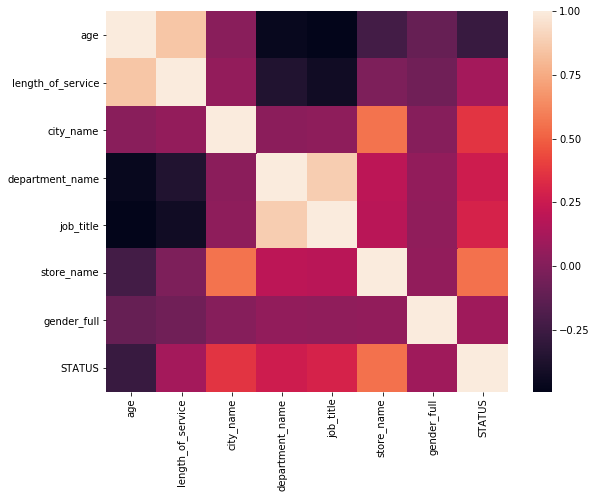

In [119]:
# let's create the correlation matrix:
correlations = train.corr()

plt.figure(figsize=(9, 7))
sns.heatmap(correlations)
plt.show()

In [120]:
# this piece of code exclude variables that are too correlated with the others:
couples = {}
drop_c = []
for i, r in correlations.iterrows():
    for j, x in r.iteritems():
        if i != j and np.abs(x) > 0.9 and i not in drop_c and j not in drop_c:
            couples[(i, j)] = (correlations.loc[i, j], correlations.loc[i, 'STATUS'], correlations.loc[j, 'STATUS'])
            drop_c.append(i)

display(pd.DataFrame(couples).T)

""


In [122]:
drop_c # variables correlated

[]

We can see that there are no variables too correlated with our target variable. So, we don't need to remove anything else.

In [123]:
X = train.drop('STATUS', 1)
Y = train['STATUS']
X_test = test.drop('STATUS', 1)
y_test = test['STATUS']

## 5. Machine learning models

In [124]:
from sklearn.metrics import roc_auc_score, roc_curve

### 5.1.1 Logistic regression

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, StandardScaler

In [126]:
from sklearn.pipeline import Pipeline

In [127]:
lr_model = Pipeline([('scaler', RobustScaler()), ('model', LogisticRegression())])

In [129]:
# let's fit the model:
lr_model.fit(X, Y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [130]:
test_preds = lr_model.predict(X)

In [131]:
test_probs_tot = lr_model.predict_proba(X)

In [132]:
# prediction:
p = pd.DataFrame(test_probs_tot)
p['pred_label'] = test_preds
p.head()

,0,1,pred_label
0,0.998065,0.001935,0
1,0.017430,0.982570,1
2,0.067371,0.932629,1
3,0.822769,0.177231,0
4,0.016502,0.983498,1


In [133]:
# list comprehensions to obtain only the probability for target == 1
test_probs = [x[1] for x in test_probs_tot]

In [134]:
# first 6 probabilities:
test_probs[0:6]

[0.0019346522149716054,
 0.982570391394254,
 0.932628894046948,
 0.1772307955092816,
 0.9834984440955142,
 0.9034256260775393]

In [135]:
# Let's compare the results obtained (prediction on train and test):
lr_probs = [y for (x, y) in lr_model.predict_proba(X)]
lr_probs_test = [y for (x, y) in lr_model.predict_proba(X_test)]

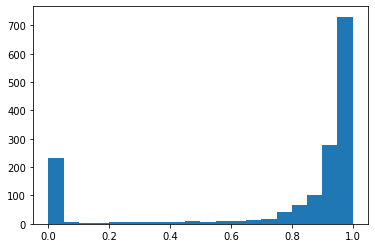

In [137]:
# plot probability distribution predicted by the model:
plt.figure()

plt.hist(lr_probs_test, bins=20)

plt.show()

In [138]:
# print the model coefficients
print('\n'.join([str((x, c)) for (x, c) in zip(X.drop(drop_c, 1).columns, lr_model.named_steps['model'].coef_[0])]))

('age', -11.85390514908247)
('length_of_service', 11.777034773861645)
('city_name', 0.3168975625729164)
('department_name', -1.0134062085686824)
('job_title', 2.4036917282410144)
('store_name', 0.780420692545926)
('gender_full', 0.33361258953468537)


In [139]:
# print auc score for train and test:
print(roc_auc_score(Y, lr_probs))
print(roc_auc_score(y_test, lr_probs_test))

0.983375215348571
0.9812903661363278


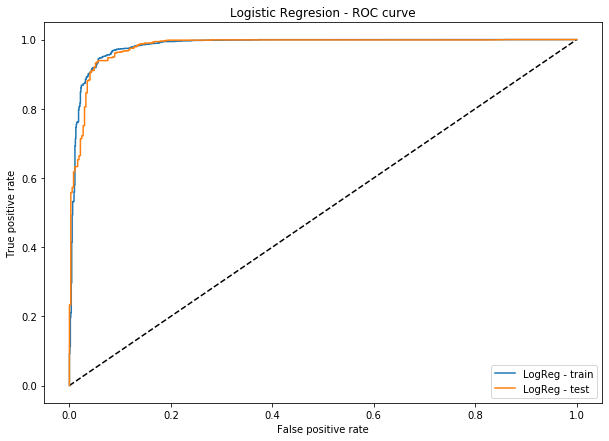

In [140]:
# let's plot the roc curve for train and test:

lr_probs = [y for (x, y) in lr_model.predict_proba(X)]
lr_probs_test = [y for (x, y) in lr_model.predict_proba(X_test)]

lr_fpr_train, lr_tpr_train, _ = roc_curve(Y, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_fpr_train, lr_tpr_train, label='LogReg - train')
plt.plot(lr_fpr, lr_tpr, label='LogReg - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regresion - ROC curve')
plt.legend(loc='best')
plt.show()

# very good ROC curve. There is a slightly difference between train and test logistic regression.

Just to have a first idea of the results of our model, we decided to visualize the confusion matrix after plotting the ROC curve. We are gonna plot and describe the confusion matrix of each model in the Model result chapter.
This is just to have an approximate idea of the results.

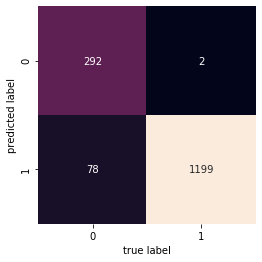

In [152]:
# confusion matrix logistic regression number 1:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, lr_model.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [153]:
import pickle as pkl

In [154]:
# we can save the estimated model as a pickle object;
# this allow us to import later and re-use it only for prediction
with open('lr_model.pkl', 'wb') as f:
    pkl.dump(lr_model, f)

### 5.1.2 Logistic regression - Alternative method

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [145]:
model = Pipeline([('scaler', RobustScaler()), ('model', LogisticRegression())])

In [147]:
# Grid search for logistic regression:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # l1 lasso l2 ridge
model = LogisticRegression()
model_cv=GridSearchCV(model,grid,cv=10) # we use the Grid Search
model_cv.fit(X,Y)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.9726288987905792


In [155]:
# find score:
logreg2=LogisticRegression(C=1000,penalty="l2").fit(X,Y)
print("score",logreg2.score(X_test,y_test))

score 0.9783577339274347


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


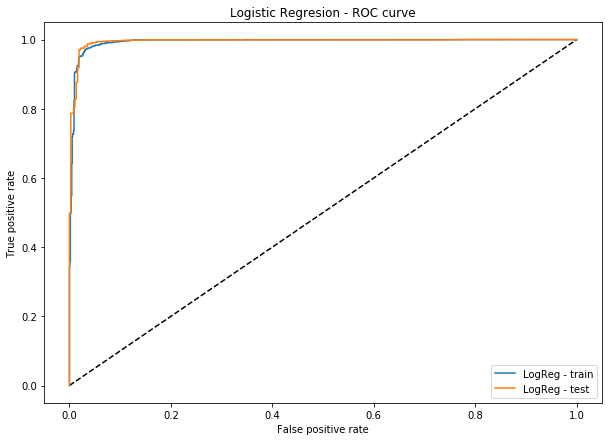

In [156]:
# plot the ROC curve:

logreg2_probs = [y for (x, y) in logreg2.predict_proba(X)]
logreg2_probs_test = [y for (x, y) in logreg2.predict_proba(X_test)]

logreg2_fpr_train, logreg2_tpr_train, _ = roc_curve(Y, logreg2_probs)
logreg2_fpr, logreg2_tpr, _ = roc_curve(y_test, logreg2_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(logreg2_fpr_train, logreg2_tpr_train, label='LogReg - train')
plt.plot(logreg2_fpr, logreg2_tpr, label='LogReg - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regresion - ROC curve')
plt.legend(loc='best')
plt.show()

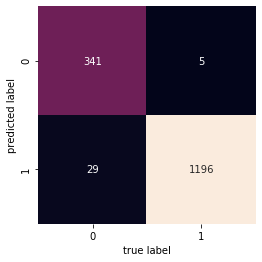

In [157]:
# confusion matrix logistic regression number 2:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, logreg2.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### 5.2.1  Decision tree

In [158]:
from sklearn.tree import DecisionTreeClassifier

In [159]:
dt = DecisionTreeClassifier(random_state=r_seed)

In [160]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [161]:
# we can create sequence of number using numpy arange function
np.arange(4, 15, 2) # this is just an example.

array([ 4,  6,  8, 10, 12, 14])

In [163]:
# first analysis: Randomized Search
# the criterion are fixed, but we can change the max_depth and the min_samples_leaf.
params = {'criterion': ['gini', 'entropy'],
          'max_depth': np.arange(4, 15, 2),
          'min_samples_leaf': [1, 0.01, 0.001]}

# parameters tuning:
cv_tuning = RandomizedSearchCV(dt, params, random_state=r_seed, scoring='roc_auc',
                               return_train_score=True, cv=5, n_iter=20)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=1123,
                                                    splitter='best')

In [164]:
print_cv(cv_tuning)

({'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}, 0.9969846940156076, 0.9882049420972437)
({'min_samples_leaf': 0.01, 'max_depth': 14, 'criterion': 'gini'}, 0.9956075419146151, 0.9888546814934838)
({'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'gini'}, 0.9898616800586559, 0.9823957872815196)
({'min_samples_leaf': 0.01, 'max_depth': 8, 'criterion': 'entropy'}, 0.9894564725004351, 0.9839240298155065)
({'min_samples_leaf': 0.001, 'max_depth': 6, 'criterion': 'entropy'}, 0.9722235875380262, 0.96766649150203)
({'min_samples_leaf': 1, 'max_depth': 4, 'criterion': 'entropy'}, 0.915811252822586, 0.9110431671919701)
({'min_samples_leaf': 0.001, 'max_depth': 14, 'criterion': 'gini'}, 0.9996966062298871, 0.9869139766143946)
({'min_samples_leaf': 0.01, 'max_depth': 14, 'criterion': 'entropy'}, 0.9954144195554919, 0.988552130497192)
({'min_samples_leaf': 0.001, 'max_depth': 4, 'criterion': 'entropy'}, 0.9158099634465102, 0.9110456672840799)
({'min_samples_leaf': 0.01, 'max_d

In [165]:
# secong analysis: Randomized Search
# we keep the same criterion. We change the max depth and the min_samples_leaf (we reduce it)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [3, 4, 5], 
          'min_samples_leaf': [0.1, 0.01, 0.001]}

# parameters tuning, removing n_iter
cv_tuning = RandomizedSearchCV(dt, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=1123,
                                                    splitter='best')

In [166]:
print_cv(cv_tuning)

({'min_samples_leaf': 0.01, 'max_depth': 4, 'criterion': 'entropy'}, 0.9149363479623387, 0.9104099348715048)
({'min_samples_leaf': 0.001, 'max_depth': 3, 'criterion': 'entropy'}, 0.8670246852534506, 0.8668810454833132)
({'min_samples_leaf': 0.01, 'max_depth': 5, 'criterion': 'gini'}, 0.9602690485636348, 0.9600627074324722)
({'min_samples_leaf': 0.1, 'max_depth': 5, 'criterion': 'gini'}, 0.8992359605829293, 0.8985794856750066)
({'min_samples_leaf': 0.01, 'max_depth': 4, 'criterion': 'gini'}, 0.912753921781821, 0.9128600251390139)
({'min_samples_leaf': 0.001, 'max_depth': 4, 'criterion': 'entropy'}, 0.9158099634465102, 0.9110456672840799)
({'min_samples_leaf': 0.01, 'max_depth': 3, 'criterion': 'gini'}, 0.8663441087207481, 0.8662778355220402)
({'min_samples_leaf': 0.001, 'max_depth': 3, 'criterion': 'gini'}, 0.8670246852534506, 0.8668810454833132)
({'min_samples_leaf': 0.1, 'max_depth': 3, 'criterion': 'entropy'}, 0.8990535192421149, 0.8962142549982373)
({'min_samples_leaf': 0.001, 'max_

In [167]:
# Let's do other analysis: 
# We did Randomized Search. Now we do Grid Search. 
# We choose entropy as criterion.
dt = DecisionTreeClassifier(random_state=r_seed, criterion='entropy')
params = {'max_depth': [4, 5], 'min_samples_leaf': [0.05, 0.01]}
cv_tuning = GridSearchCV(dt, params, scoring='roc_auc', return_train_score=True, cv=5)

In [168]:
cv_tuning.fit(X, Y)
print('\n'.join([str((x, y, z)) for (x, y, z) in zip(cv_tuning.cv_results_['params'], cv_tuning.cv_results_['mean_train_score'], cv_tuning.cv_results_['mean_test_score'])]))

({'max_depth': 4, 'min_samples_leaf': 0.05}, 0.9263664506170425, 0.9238384445628687)
({'max_depth': 4, 'min_samples_leaf': 0.01}, 0.9149363479623387, 0.9104099348715048)
({'max_depth': 5, 'min_samples_leaf': 0.05}, 0.9506007607069737, 0.9503932172752045)
({'max_depth': 5, 'min_samples_leaf': 0.01}, 0.958922737818469, 0.9554419121907134)


In [169]:
# Another:
dt = DecisionTreeClassifier(random_state=r_seed, criterion='entropy',
                            max_depth=4, min_samples_leaf=0.01)

dt.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1123, splitter='best')

In [170]:
# Let's compare the results obtained (prediction on train and test):
dt_probs = [y for (x, y) in dt.predict_proba(X)]
dt_probs_test = [y for (x, y) in dt.predict_proba(X_test)]

In [171]:
# auc score for train and test:
print('Train set auc: {}'.format(roc_auc_score(Y, dt_probs))) # train
print('Train set auc: {}'.format(roc_auc_score(y_test, dt_probs_test))) #test

Train set auc: 0.9127402589933814
Train set auc: 0.9158269010059185


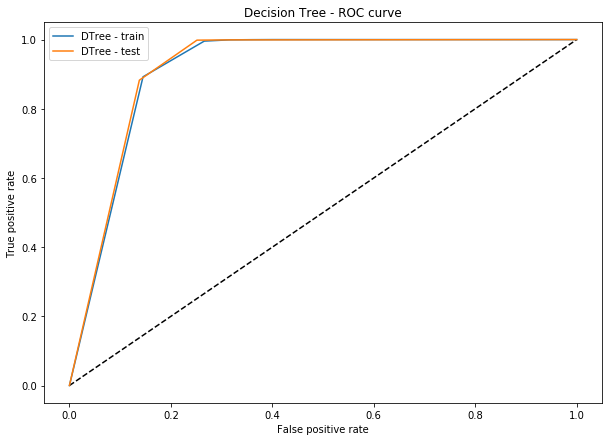

In [172]:
# plot ROC curve:

dt_fpr_train, dt_tpr_train, _ = roc_curve(Y, dt_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(dt_fpr_train, dt_tpr_train, label='DTree - train')
plt.plot(dt_fpr, dt_tpr, label='DTree - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Decision Tree - ROC curve')
plt.legend(loc='best')
plt.show()

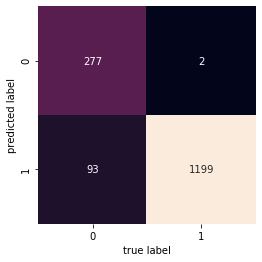

In [173]:
# confusion matrix for decision tree number 1:

from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, dt.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [174]:
with open('dt_model.pkl', 'wb') as f:
    pkl.dump(dt, f)

### 5.2.2 Decision Tree - Alternative model

In [175]:
# Let's do a Grid Search:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':range(3,20)}
tree=DecisionTreeClassifier()
clf = GridSearchCV(tree, parameters, n_jobs=4)
clf.fit(X=X, y=Y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
# print best score:

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9898154042011458 {'max_depth': 15}


In [176]:
# find score:
tree=DecisionTreeClassifier()
tree=DecisionTreeClassifier(max_depth=18).fit(X,Y)
print("score",tree.score(X_test,y_test))

score 0.9859961807765755


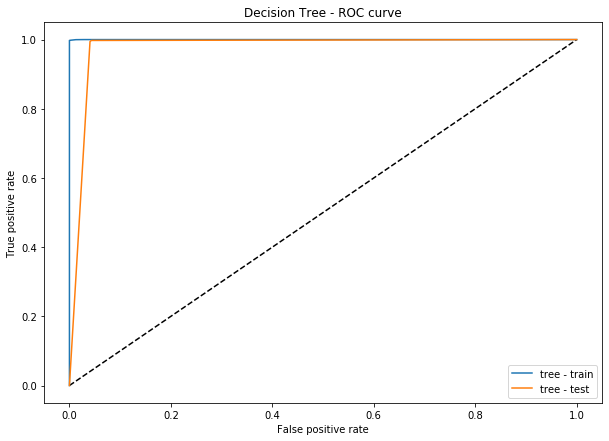

In [234]:
# plot the ROC curve:
tree_probs = [y for (x, y) in tree.predict_proba(X)]
tree_probs_test = [y for (x, y) in tree.predict_proba(X_test)]

tree_fpr_train, tree_tpr_train, _ = roc_curve(Y, tree_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_test, tree_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tree_fpr_train, tree_tpr_train, label='tree - train')
plt.plot(tree_fpr, tree_tpr, label='tree - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Decision Tree - ROC curve')
plt.legend(loc='best')
plt.show()

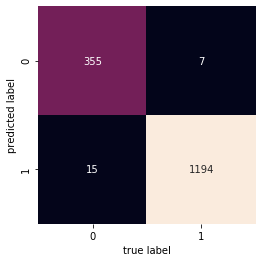

In [178]:
# confusion matrix for decision tree number 2:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, tree.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### 5.3 Random forest

In [179]:
# this function allows to extract the split of the tree in a readable way
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * (depth-1)
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, str(round(tree_.value[node][0][1] / (tree_.value[node][0][0] + tree_.value[node][0][1]) * 100, 2)) + '%'))

    recurse(0, 1)

In [180]:
tree_to_code(dt, X.columns)

if age <= 64.5:
  if store_name <= 0.6560005843639374:
    if city_name <= 0.7773118019104004:
      return 0.0%
    else:  # if city_name > 0.7773118019104004
      return 19.4%
  else:  # if store_name > 0.6560005843639374
    if length_of_service <= 1.5:
      if city_name <= 0.7883607745170593:
        return 0.0%
      else:  # if city_name > 0.7883607745170593
        return 3.85%
    else:  # if length_of_service > 1.5
      if age <= 59.5:
        return 95.23%
      else:  # if age > 59.5
        return 73.52%
else:  # if age > 64.5
  if city_name <= 0.7671458721160889:
    if store_name <= 0.20439254492521286:
      return 2.04%
    else:  # if store_name > 0.20439254492521286
      return 0.0%
  else:  # if city_name > 0.7671458721160889
    return 0.0%


In [181]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=r_seed, n_estimators=50)

In [182]:
np.logspace(-1, -3, 3)

array([0.1  , 0.01 , 0.001])

In [183]:
# First analysis: Randomized Search 
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2, 3, 4, 5],
          'min_samples_leaf': np.logspace(-1, -3, 3)} #[0.1, 0.01, 0.001]

# parameters tuning:
cv_tuning = RandomizedSearchCV(rf, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5, n_iter=20)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                                    n_jobs=None,
  

In [184]:
print_cv(cv_tuning)

({'min_samples_leaf': 0.1, 'max_depth': 4, 'criterion': 'entropy'}, 0.8894336032167569, 0.8871052777371721)
({'min_samples_leaf': 0.01, 'max_depth': 2, 'criterion': 'entropy'}, 0.9141722247852252, 0.9136034004302468)
({'min_samples_leaf': 0.01, 'max_depth': 5, 'criterion': 'gini'}, 0.9614674202882453, 0.9593475543832977)
({'min_samples_leaf': 0.01, 'max_depth': 5, 'criterion': 'entropy'}, 0.9656273974685835, 0.9633830623206091)
({'min_samples_leaf': 0.1, 'max_depth': 3, 'criterion': 'gini'}, 0.8875688897618582, 0.8856380605382925)
({'min_samples_leaf': 0.01, 'max_depth': 4, 'criterion': 'gini'}, 0.9352690997683988, 0.9331817612171321)
({'min_samples_leaf': 0.001, 'max_depth': 5, 'criterion': 'entropy'}, 0.9654963871929837, 0.9617636234422279)
({'min_samples_leaf': 0.01, 'max_depth': 2, 'criterion': 'gini'}, 0.9100456439808537, 0.9111142514983293)
({'min_samples_leaf': 0.01, 'max_depth': 4, 'criterion': 'entropy'}, 0.942426817286567, 0.9400083860813221)
({'min_samples_leaf': 0.01, 'max_

In [185]:
# Second analysis: Randomized Search 
# we fix the criterion and we change the max_depth, min_samples_leaf and max_features

rf = RandomForestClassifier(random_state=r_seed, n_estimators=50, criterion='gini')

params = {'max_depth': [2, 3],
          'min_samples_leaf': [0.01, 0.001, 1],
          'max_features': ['sqrt', 0.2, 0.5]}
# parameters tuning:
cv_tuning = RandomizedSearchCV(rf, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                                    n_jobs=None,
  

In [186]:
print_cv(cv_tuning)

({'min_samples_leaf': 0.001, 'max_features': 0.2, 'max_depth': 3}, 0.9226117867385908, 0.9218618447869573)
({'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3}, 0.9218875678216992, 0.9199770054006117)
({'min_samples_leaf': 0.001, 'max_features': 0.5, 'max_depth': 2}, 0.9152279649213504, 0.9129456290517595)
({'min_samples_leaf': 0.01, 'max_features': 0.5, 'max_depth': 2}, 0.9141684302384332, 0.9131500187344742)
({'min_samples_leaf': 0.001, 'max_features': 0.2, 'max_depth': 2}, 0.9201000156632906, 0.9193844659952916)
({'min_samples_leaf': 1, 'max_features': 0.2, 'max_depth': 3}, 0.9234999679044528, 0.922187052210714)
({'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'max_depth': 2}, 0.9083700509305299, 0.9090130788611444)
({'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 2}, 0.9083721999448701, 0.9090024534696781)
({'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 3}, 0.9226789714007824, 0.9213188823506753)
({'min_samples_leaf': 1, 'max_features':

In [187]:
# Let's do other analysis: 
# We did Randomized Search. Now we do Grid Search. 
# We choose gini as criterion.

rf = RandomForestClassifier(random_state=r_seed, n_estimators=50, criterion='gini', max_depth=3)

params = {'min_samples_leaf': [0.01, 0.001], # same as before
          'max_features': [0.2, 0.3, 0.4, 0.5]}

# parameters tuning:
cv_tuning = GridSearchCV(rf, params, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random_state=1123, verbose=0,
                                              warm_start=False),
             iid='warn'

In [188]:
rf = RandomForestClassifier(random_state=r_seed, n_estimators=50,
                            criterion='gini', max_depth=3,
                            min_samples_leaf=0.001, max_features=0.5,
                            warm_start=True)

# now we tune the number of estimator
for i in range(5):
    rf.fit(X, Y)
    probs = [y for (x, y) in rf.predict_proba(X)]
    probs_test = [y for (x, y) in rf.predict_proba(X_test)]
    print(rf.n_estimators, roc_auc_score(Y, probs), roc_auc_score(y_test, probs_test))
    rf.n_estimators += 50

50 0.9154527133294826 0.9257364358530054
100 0.9177520984764949 0.9265083151427864
150 0.9252983624757147 0.9322805319891081
200 0.9257531886591005 0.9332076872876206
250 0.9261870113243968 0.9329252649818844


In [197]:
# we redo the Random Forest Classifier changing the number of estimators. 
# we choose 150 estimators because we have the smaller difference between train and test. 

rf = RandomForestClassifier(random_state=r_seed, n_estimators=150,
                            criterion='gini', max_depth=3,
                            min_samples_leaf=0.001, max_features=0.5,
                            warm_start=True)

rf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=1123,
                       verbose=0, warm_start=True)

In [198]:
# Let's compare the results obtained (prediction on train and test):
rf_probs = [y for (x, y) in rf.predict_proba(X)]
rf_probs_test = [y for (x, y) in rf.predict_proba(X_test)]

# Print auc score:
print(roc_auc_score(Y, rf_probs))
print(roc_auc_score(y_test, rf_probs_test))

0.9252983624757147
0.9322805319891081


In [199]:
# print the coefficients:
feats = [(x, y) for x, y in zip(X.columns, rf.feature_importances_) if y > 0]
sorted(feats, reverse=True, key=lambda x: x[1])

[('age', 0.42881207874646915),
 ('store_name', 0.3068191629751263),
 ('length_of_service', 0.11733369779542989),
 ('city_name', 0.11111312551890414),
 ('job_title', 0.022755820482529648),
 ('department_name', 0.013099613523184641),
 ('gender_full', 6.650095835622588e-05)]

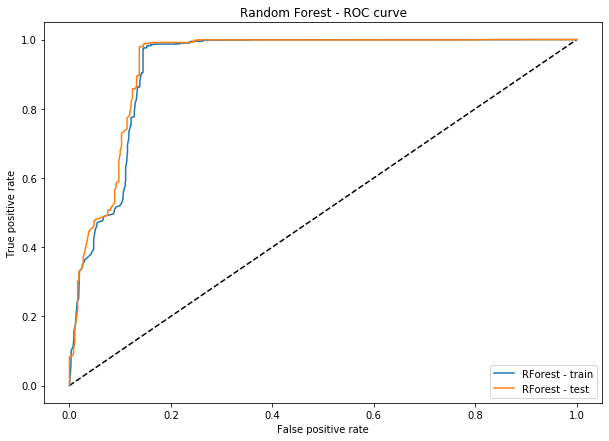

In [200]:
# Plot the ROC curve:
rf_fpr_train, rf_tpr_train, _ = roc_curve(Y, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr_train, rf_tpr_train, label='RForest - train')
plt.plot(rf_fpr, rf_tpr, label='RForest - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest - ROC curve')
plt.legend(loc='best')
plt.show()

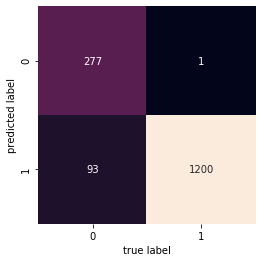

In [201]:
# confusion matrix for random forest number 1:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [202]:
with open('rf_model.pkl', 'wb') as f:
    pkl.dump(rf, f)

### 5.3.2 Random Forest - Alternative method

In [203]:
from sklearn.ensemble import RandomForestRegressor
rf2 = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.001,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1123,
 'verbose': 0,
 'warm_start': True}


In [204]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create the parameter grid based on the results of random search 
param_grid1 = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf2 = RandomForestClassifier()
# Instantiate the grid search model
grid_search1 = GridSearchCV(estimator = rf2, param_grid = param_grid1, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [207]:
# Fit the grid search to the data
grid_search1.fit(X, Y)
grid_search1.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  8.3min finished


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [209]:
best_grid1 = grid_search1.best_estimator_
best_grid1.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

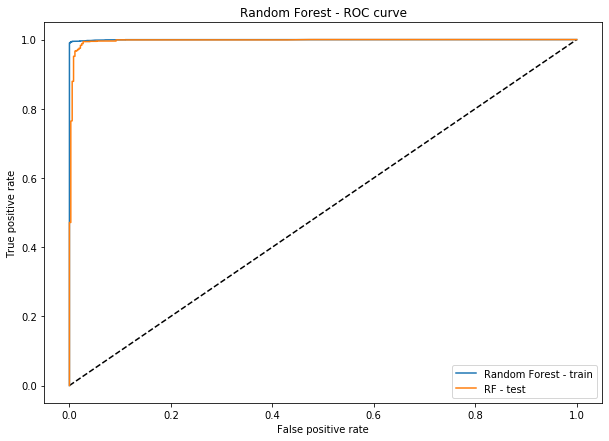

In [210]:
# Plot the ROC curve:
best_grid1_probs = [y for (x, y) in best_grid1.predict_proba(X)]
best_grid1_probs_test = [y for (x, y) in best_grid1.predict_proba(X_test)]

best_grid1_fpr_train, best_grid1_tpr_train, _ = roc_curve(Y, best_grid1_probs)
best_grid1_fpr, best_grid1_tpr, _ = roc_curve(y_test, best_grid1_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(best_grid1_fpr_train, best_grid1_tpr_train, label='Random Forest - train')
plt.plot(best_grid1_fpr, best_grid1_tpr, label='RF - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest - ROC curve')
plt.legend(loc='best')
plt.show()

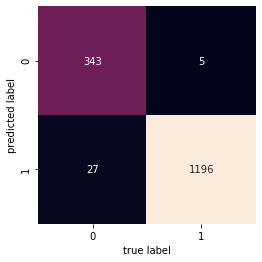

In [212]:
# Confusion matrix for random forest number 2:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, best_grid1.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### 5.4.1 Gradient boosting

In [213]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=r_seed, n_estimators=50)

In [214]:
np.logspace(0,-3,3) # initial value of the learning rate

array([1.        , 0.03162278, 0.001     ])

In [215]:
# First analysis Randomized Search:
params = {'loss' :['deviance', 'exponential'],
          'learning_rate' : np.logspace(0, -3, 4), # initial set for the learning rate
          'subsample' : np.logspace(0, -3, 3),
          'max_features': ['sqrt','log2', 0.2, 0.5,0.8,1],
          'min_samples_split' : np.logspace(-1, -3, 3),
        }

# parameters tuning:
cv_tuning = RandomizedSearchCV(gb,
                               params,
                               random_state=r_seed,
                               n_iter = 20, # how many iterations
                               scoring='roc_auc', 
                               return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

# If I give a learning rate too high, the algorithm will never reach the optimum. 
# In contrast, a value that is too small could take too many iterations to reach the minimum so it is not efficient. 
# We have to find the parameter that is optimal to have the best estimation of the parameter.
# The other parameter is the cross validation (we have seen it in random forest)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [216]:
print_cv(cv_tuning) 
# the last 2 numbers in the first row are the score in the train set and test set
# 0.5 is random guess. it is a straight line

({'subsample': 0.001, 'min_samples_split': 0.01, 'max_features': 0.2, 'loss': 'deviance', 'learning_rate': 0.001}, 0.5, 0.5)
({'subsample': 1.0, 'min_samples_split': 0.1, 'max_features': 1, 'loss': 'exponential', 'learning_rate': 0.1}, 0.9632468335049834, 0.9591878502071517)
({'subsample': 0.001, 'min_samples_split': 0.1, 'max_features': 'sqrt', 'loss': 'deviance', 'learning_rate': 0.1}, 0.5, 0.5)
({'subsample': 1.0, 'min_samples_split': 0.01, 'max_features': 0.5, 'loss': 'deviance', 'learning_rate': 1.0}, 0.8882939653488183, 0.8903098390177611)
({'subsample': 1.0, 'min_samples_split': 0.01, 'max_features': 'log2', 'loss': 'exponential', 'learning_rate': 0.1}, 0.9782879810976537, 0.9732317329150556)
({'subsample': 1.0, 'min_samples_split': 0.1, 'max_features': 0.2, 'loss': 'exponential', 'learning_rate': 0.001}, 0.9249034776780505, 0.9229339230520377)
({'subsample': 1.0, 'min_samples_split': 0.1, 'max_features': 1, 'loss': 'deviance', 'learning_rate': 0.01}, 0.9288440138875735, 0.92663

In [218]:
# Second analysis: let's do another Randomized Search based on a reduced set of parameters
# The first analysis is not good because we have 0.5 as score:
params = {'loss' :['deviance', 'exponential'],
          'learning_rate' : [0.001,0.0001,0.01], # change this
          'subsample' : np.logspace(0, -3, 3),
          'max_features': ['sqrt','log2', 0.2, 0.5,0.8,1],
          'min_samples_split' : np.logspace(-1, -3, 3),
        }

cv_tuning = RandomizedSearchCV(gb,
                               params,
                               random_state=r_seed,
                               n_iter = 20,
                               scoring='roc_auc', 
                               return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [219]:
print_cv(cv_tuning)

({'subsample': 0.001, 'min_samples_split': 0.01, 'max_features': 0.8, 'loss': 'deviance', 'learning_rate': 0.01}, 0.5, 0.5)
({'subsample': 0.001, 'min_samples_split': 0.01, 'max_features': 0.8, 'loss': 'exponential', 'learning_rate': 0.01}, 0.5, 0.5)
({'subsample': 0.001, 'min_samples_split': 0.001, 'max_features': 0.5, 'loss': 'exponential', 'learning_rate': 0.001}, 0.5, 0.5)
({'subsample': 0.001, 'min_samples_split': 0.01, 'max_features': 'sqrt', 'loss': 'deviance', 'learning_rate': 0.001}, 0.5, 0.5)
({'subsample': 0.03162277660168379, 'min_samples_split': 0.1, 'max_features': 0.5, 'loss': 'exponential', 'learning_rate': 0.01}, 0.5, 0.5)
({'subsample': 0.03162277660168379, 'min_samples_split': 0.01, 'max_features': 0.5, 'loss': 'exponential', 'learning_rate': 0.01}, 0.9395762253585191, 0.9405087023116013)
({'subsample': 0.001, 'min_samples_split': 0.001, 'max_features': 0.5, 'loss': 'deviance', 'learning_rate': 0.01}, 0.5, 0.5)
({'subsample': 0.03162277660168379, 'min_samples_split':

In [220]:
# Now, let's do a Grid Search:
params = {'loss' :['deviance', 'exponential'],
          'learning_rate' : [0.001,0.0001,0.01],
          'subsample' : [1,0.9], # change this
          'max_features': ['sqrt','log2', 0.2, 0.5,0.8,1],
          'min_samples_split' : np.logspace(-1, -3, 3),
        }

cv_tuning = GridSearchCV(gb, params, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=50,
                                                  n_iter_no_...
                                                  validation_fractio

In [221]:
print_cv(cv_tuning) # I found a good set of hyper parameters

({'learning_rate': 0.001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_split': 0.1, 'subsample': 1}, 0.9222991590743257, 0.9208930295389663)
({'learning_rate': 0.001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_split': 0.1, 'subsample': 0.9}, 0.923403248787063, 0.9197511694854693)
({'learning_rate': 0.001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_split': 0.01, 'subsample': 1}, 0.9211442925598922, 0.9181466349042116)
({'learning_rate': 0.001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_split': 0.01, 'subsample': 0.9}, 0.9290594377511333, 0.927303302212109)
({'learning_rate': 0.001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_split': 0.001, 'subsample': 1}, 0.9236099977802125, 0.9209357757287698)
({'learning_rate': 0.001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_split': 0.001, 'subsample': 0.9}, 0.9304497322094389, 0.927702232107201)
({'learning_rate': 0.001, 'loss': 'deviance', 'max_features': 'log2', 'mi

In [222]:
# this command puts together all the results of the grid search. I ordered by the result on the test set and then I choose the second best one
result_cv = pd.DataFrame([(p,tr,te) for (p,tr,te) in zip(cv_tuning.cv_results_['params'],cv_tuning.cv_results_['mean_train_score'],cv_tuning.cv_results_['mean_test_score']) if te > 0.84]).sort_values(2,ascending=[0])
result_cv

# I choose the second (also the first one was ok). The first 10 models are all very good.

,0,1,2
206,"{'learning_rate': 0.01, 'loss': 'exponential',...",0.937873,0.939319
208,"{'learning_rate': 0.01, 'loss': 'exponential',...",0.937039,0.938346
159,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.937707,0.936667
177,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.937707,0.936667
105,"{'learning_rate': 0.0001, 'loss': 'deviance', ...",0.937971,0.936532
...,...,...,...
136,"{'learning_rate': 0.0001, 'loss': 'exponential...",0.906814,0.901814
132,"{'learning_rate': 0.0001, 'loss': 'exponential...",0.905674,0.900677
100,"{'learning_rate': 0.0001, 'loss': 'deviance', ...",0.905332,0.900211
96,"{'learning_rate': 0.0001, 'loss': 'deviance', ...",0.903106,0.897750


In [223]:
result_cv.reset_index(drop=True,inplace=True)
result_cv.loc[2][0]

{'learning_rate': 0.01,
 'loss': 'deviance',
 'max_features': 0.2,
 'min_samples_split': 0.01,
 'subsample': 0.9}

In [224]:
gb_best = GradientBoostingClassifier(learning_rate=0.01,
                                     loss='deviance',
                                     max_features = 0.2,
                                     min_samples_split = 0.01,
                                     subsample = 0.9,
                                     random_state=r_seed,
                                     n_estimators=50)

gb_best.fit(X,Y)

# now we tune the number of estimator
for i in range(10):
    gb_best.fit(X, Y)
    probs = [y for (x, y) in gb_best.predict_proba(X)]
    probs_test = [y for (x, y) in gb_best.predict_proba(X_test)]
    print(gb_best.n_estimators, roc_auc_score(Y, probs), roc_auc_score(y_test, probs_test))
    print(max(probs_test))
    gb_best.n_estimators += 50
    
# the first number is the number of estimators of the gradient boosting
# second and third number are the scores of train set and test set 

# Which number of estimators I will choose? I have to stop when the improvement of the train set is higher than the improvement of test set (overfitting)
# It is never higher. We will choose the estimator with the slighest difference between train and test.
# So we will choose around 400.

50 0.9251557135820251 0.9325280734523032
0.8165811147014013
100 0.9276940137473028 0.934920224137543
0.8551614258637338
150 0.9323965514223633 0.9382485316290479
0.8832211425349787
200 0.9422693301127939 0.9472174089159933
0.9042966512954905
250 0.9444644477950056 0.9492753786259199
0.9216888061753925
300 0.9472367871618497 0.95151000292549
0.9344331896659757
350 0.9519005683451978 0.9547347930778407
0.9451399475825483
400 0.9539336588878637 0.9566554897945406
0.9525305840911268
450 0.9573368539230321 0.9599342889934064
0.9597250176296577
500 0.9590683939559876 0.9614971757769426
0.965005467305188


In [225]:
# final configuration of the model
gb_best = GradientBoostingClassifier(learning_rate=0.01,
                                     loss='deviance',
                                     max_features = 0.2,
                                     min_samples_split = 0.01,
                                     subsample = 0.9,
                                     random_state=r_seed,
                                     n_estimators=400)

gb_best.fit(X,Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=0.2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.01,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='auto',
                           random_state=1123, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [226]:
# calculate probability:
gb_probs = [y for (x, y) in gb_best.predict_proba(X)]
gb_probs_test = [y for (x, y) in gb_best.predict_proba(X_test)]

# calculate auc score:
print(roc_auc_score(Y, gb_probs))
print(roc_auc_score(y_test, gb_probs_test))

0.9539336588878637
0.9566554897945406


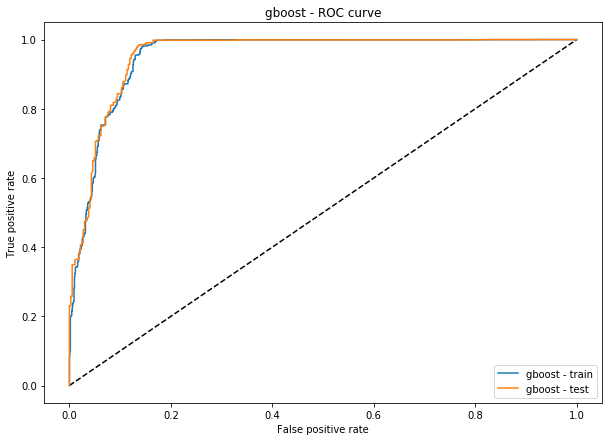

In [227]:
# Plot the ROC curve:
gb_fpr_train, gb_tpr_train, _ = roc_curve(Y, gb_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(gb_fpr_train, gb_tpr_train, label='gboost - train')
plt.plot(gb_fpr, gb_tpr, label='gboost - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('gboost - ROC curve')
plt.legend(loc='best')
plt.show()

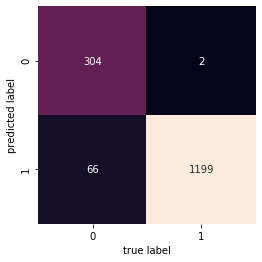

In [228]:
# Confusion matrix for gradient boosting number 1:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, gb_best.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [229]:
with open('gb_model.pkl', 'wb') as f:
    pkl.dump(gb_best, f)

### 5.4.2 Gradient Boosting - Alternative Method

In [230]:
gb = GradientBoostingClassifier(random_state=0)

In [231]:
# learning rate because it is a method based on the gradient
params = {'learning_rate': np.logspace(-1, -4, 4),
          'min_samples_leaf': np.logspace(-1, -4, 4), 
          'max_features': ['sqrt', 0.2, 0.3, 0.5, 0.7, 0.8]}
cv_tuning = GridSearchCV(gb, params, scoring='roc_auc', return_train_score=True, cv=5)
cv_tuning.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  random_state=0, su

In [232]:
cv_tuning.best_params_

{'learning_rate': 0.1, 'max_features': 0.8, 'min_samples_leaf': 0.01}

In [233]:
best_grid = cv_tuning.best_estimator_
best_grid.fit(X, Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.01, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

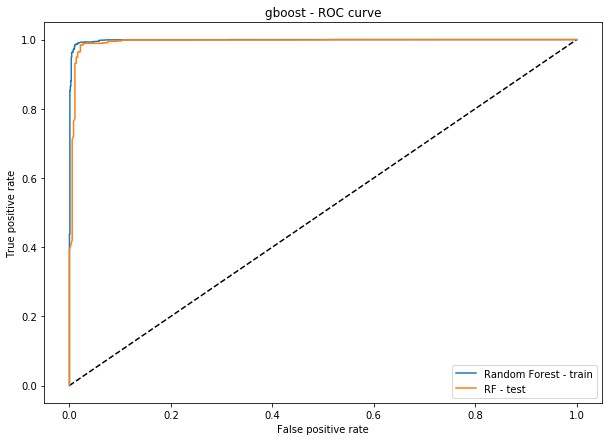

In [235]:
# Plot the ROC curve:
best_grid_probs = [y for (x, y) in best_grid.predict_proba(X)]
best_grid_probs_test = [y for (x, y) in best_grid.predict_proba(X_test)]

best_grid_fpr_train, best_grid_tpr_train, _ = roc_curve(Y, best_grid_probs)
best_grid_fpr, best_grid_tpr, _ = roc_curve(y_test, best_grid_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(best_grid_fpr_train, best_grid_tpr_train, label='Random Forest - train')
plt.plot(best_grid_fpr, best_grid_tpr, label='RF - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('gboost - ROC curve')
plt.legend(loc='best')
plt.show()

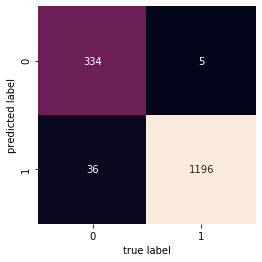

In [236]:
# Confusion matrix for gradient boosting number 2:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, best_grid.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### 5.5.1 Neural Network:

In [237]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(random_state=r_seed, max_iter=50)

In [238]:
import warnings

warnings.filterwarnings('ignore')

In [239]:
# First analysis Randomized Search:
params = {'activation': ['tanh', 'relu'], # choose always these 2 activation functions
          'learning_rate_init': np.logspace(-1, -4, 4),  
          'batch_size': [16, 32, 64]}

cv_tuning = RandomizedSearchCV(nn, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5, n_iter=20)

cv_tuning.fit(X, Y)

print_cv(cv_tuning)

({'learning_rate_init': 0.001, 'batch_size': 32, 'activation': 'relu'}, 0.9953013376833386, 0.995125366601855)
({'learning_rate_init': 0.01, 'batch_size': 16, 'activation': 'relu'}, 0.9954926644060498, 0.9950454421301944)
({'learning_rate_init': 0.001, 'batch_size': 64, 'activation': 'tanh'}, 0.9954007266453152, 0.9950427969395079)
({'learning_rate_init': 0.001, 'batch_size': 64, 'activation': 'relu'}, 0.994153812058984, 0.9935813181656378)
({'learning_rate_init': 0.0001, 'batch_size': 16, 'activation': 'tanh'}, 0.9927951954048935, 0.9923384776939499)
({'learning_rate_init': 0.0001, 'batch_size': 32, 'activation': 'tanh'}, 0.9914398903897755, 0.9910744759508457)
({'learning_rate_init': 0.0001, 'batch_size': 64, 'activation': 'relu'}, 0.9700021360220461, 0.9697745593704973)
({'learning_rate_init': 0.01, 'batch_size': 16, 'activation': 'tanh'}, 0.9929747463330086, 0.9918184380987123)
({'learning_rate_init': 0.0001, 'batch_size': 32, 'activation': 'relu'}, 0.9890108962068037, 0.9888366674

In [240]:
# Second analysis Randomized Search:
# lets do it again and train the layer size:
# The difference of this model is that I add a multiple fully connected neural
nn = MLPClassifier(random_state=r_seed, activation='tanh', max_iter=50, learning_rate_init=0.0001)

params = {'batch_size': [16, 32, 64], 
          'hidden_layer_sizes': np.arange(20, 101, 20)}

cv_tuning = RandomizedSearchCV(nn, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5, n_iter=10)

cv_tuning.fit(X, Y)

print_cv(cv_tuning)

({'hidden_layer_sizes': 40, 'batch_size': 32}, 0.9891025997104868, 0.9885951241223222)
({'hidden_layer_sizes': 100, 'batch_size': 16}, 0.9927951954048935, 0.9923384776939499)
({'hidden_layer_sizes': 40, 'batch_size': 64}, 0.9757854831942734, 0.9754251893461195)
({'hidden_layer_sizes': 100, 'batch_size': 32}, 0.9914398903897755, 0.9910744759508457)
({'hidden_layer_sizes': 40, 'batch_size': 16}, 0.9913449598745807, 0.9909006553788648)
({'hidden_layer_sizes': 60, 'batch_size': 16}, 0.9915565240536843, 0.9913032572676731)
({'hidden_layer_sizes': 60, 'batch_size': 32}, 0.9902302917428105, 0.9899179871604831)
({'hidden_layer_sizes': 20, 'batch_size': 32}, 0.9872176676384286, 0.9868797960790723)
({'hidden_layer_sizes': 80, 'batch_size': 16}, 0.9925450590755298, 0.9921872029110786)
({'hidden_layer_sizes': 100, 'batch_size': 64}, 0.9874833527321591, 0.98719507213216)


In [241]:
# Let's fo a Grid Search:
params = {'batch_size': [16, 32], 'hidden_layer_sizes': [100, 120, 150]}

cv_tuning = GridSearchCV(nn, params, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

print_cv(cv_tuning)

({'batch_size': 16, 'hidden_layer_sizes': 100}, 0.9927951954048935, 0.9923384776939499)
({'batch_size': 16, 'hidden_layer_sizes': 120}, 0.9921131152574425, 0.9917558274829478)
({'batch_size': 16, 'hidden_layer_sizes': 150}, 0.9925137487854441, 0.9922159180022424)
({'batch_size': 32, 'hidden_layer_sizes': 100}, 0.9914398903897755, 0.9910744759508457)
({'batch_size': 32, 'hidden_layer_sizes': 120}, 0.9904130439309682, 0.9902067653744743)
({'batch_size': 32, 'hidden_layer_sizes': 150}, 0.9911623669660383, 0.9908093484734423)


In [242]:
nn = MLPClassifier(random_state=r_seed, activation='tanh', max_iter=500,
                   learning_rate_init=0.0001, batch_size=16,
                   hidden_layer_sizes=(120,), verbose=True,
                   n_iter_no_change=100, tol=1e-5)

nn.fit(X, Y)

Iteration 1, loss = 0.55523192
Iteration 2, loss = 0.45557387
Iteration 3, loss = 0.39757931
Iteration 4, loss = 0.36097638
Iteration 5, loss = 0.33474930
Iteration 6, loss = 0.31076206
Iteration 7, loss = 0.28902523
Iteration 8, loss = 0.26665242
Iteration 9, loss = 0.24576626
Iteration 10, loss = 0.22801252
Iteration 11, loss = 0.21117334
Iteration 12, loss = 0.19605708
Iteration 13, loss = 0.18228206
Iteration 14, loss = 0.17063531
Iteration 15, loss = 0.16083218
Iteration 16, loss = 0.15192362
Iteration 17, loss = 0.14473336
Iteration 18, loss = 0.13814282
Iteration 19, loss = 0.13203344
Iteration 20, loss = 0.12667169
Iteration 21, loss = 0.12247295
Iteration 22, loss = 0.11839315
Iteration 23, loss = 0.11450536
Iteration 24, loss = 0.11117913
Iteration 25, loss = 0.10899579
Iteration 26, loss = 0.10617996
Iteration 27, loss = 0.10337841
Iteration 28, loss = 0.10151462
Iteration 29, loss = 0.09970281
Iteration 30, loss = 0.09761978
Iteration 31, loss = 0.09620639
Iteration 32, los

MLPClassifier(activation='tanh', alpha=0.0001, batch_size=16, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(120,), learning_rate='constant',
              learning_rate_init=0.0001, max_iter=500, momentum=0.9,
              n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
              random_state=1123, shuffle=True, solver='adam', tol=1e-05,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [243]:
# calculate probability prediction:
nn_probs = [y for (x, y) in nn.predict_proba(X)]
nn_probs_test = [y for (x, y) in nn.predict_proba(X_test)]

# calculate auc score:
print(roc_auc_score(Y, nn_probs))
print(roc_auc_score(y_test, nn_probs_test))

0.9977888796373392
0.9983459729504691


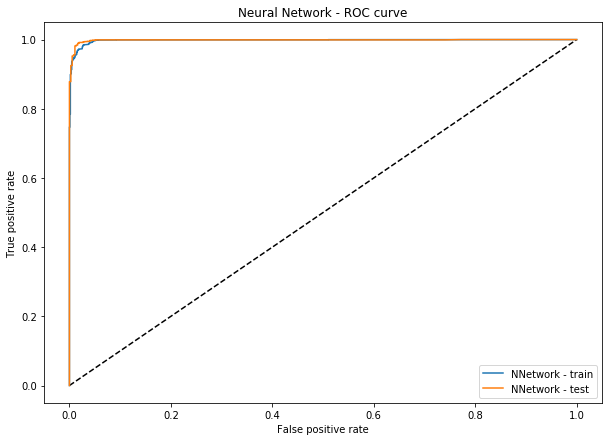

In [244]:
# Plot the ROC curve:
nn_fpr_train, nn_tpr_train, _ = roc_curve(Y, nn_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(nn_fpr_train, nn_tpr_train, label='NNetwork - train')
plt.plot(nn_fpr, nn_tpr, label='NNetwork - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Neural Network - ROC curve')
plt.legend(loc='best')
plt.show()

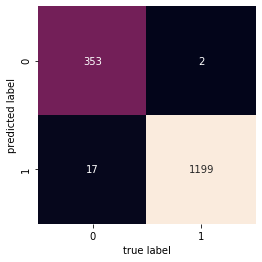

In [245]:
# Confusion matrix for neural network:
mat = confusion_matrix(y_test, nn.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [246]:
with open('nn_model.pkl', 'wb') as f:
    pkl.dump(nn, f)

### 5.5.2 Alternative Neural Network:
We didn't provide an alternative to neural network because the algorithm was too computational expensive. We try to run it for a long time, but it wasn't worth to wait given the very good model we have already created above. So, we decided to keep only our first representation.

## 6. Model comparison

As we mentioned previously, we gave some alternatives to the models, with different procedures and different train and test splittings. The role of a data scientist isn't just to perform an algorithm and look at the performances. It is a loop over the action of performing an algorithm, look at its performance and turn back, by trying to improve it and gain a better prediction every time, by trying many methods, many splitting and a lot of 'Parameter tuning work'. 

In our two solutions to the models we tried to solve a trade-off. The first method is the simplest and more intuitive, and also less time consuming and computational consuming, even if it doesn't seem to be. This method consists in tuning one or few parameters at one time and look at the best outcome in terms of accuracy of the prediction. 

The second method tune each parater of the model in one-shot Grid search cross validation. This method gave us a better accuracy in the prediction but it was more computational consuming and it takes more time to run. 

Here we will summarize and compare just the first options of the models. 

In [247]:
import pickle as pkl
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [248]:
import warnings
warnings.filterwarnings('ignore')

In [249]:
# define the function to do the confusion matrix we are gonna do later:
def pretty_confusion_matrix(y, preds):
    return pd.DataFrame(confusion_matrix(y, preds),
                        columns=pd.MultiIndex(levels=[['prediction'], ['0', '1']], codes=[[0, 0], [0, 1]]),
                        index=pd.MultiIndex(levels=[['STATUS'], ['0', '1']], codes=[[0, 0], [0, 1]]))

In [250]:
# open all the models that we have saved previously:

with open('lr_model.pkl', 'rb') as f:
    lr = pkl.load(f)

with open('dt_model.pkl', 'rb') as f:
    dt = pkl.load(f)

with open('rf_model.pkl', 'rb') as f:
    rf = pkl.load(f)

with open('gb_model.pkl', 'rb') as f:
    gb = pkl.load(f)

with open('nn_model.pkl', 'rb') as f:
    nn = pkl.load(f)

In [251]:
# open train and test 
train = pd.read_csv('train')
test = pd.read_csv('test')

X = train.drop('STATUS', 1)
Y = train['STATUS']
X_test = test.drop('STATUS', 1)
y_test = test['STATUS']

In [252]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [253]:
# recall all the models previously done:
lr_preds = lr.predict(X_test)
lr_probs_train = [y for (x, y) in lr.predict_proba(X)]
lr_probs = [y for (x, y) in lr.predict_proba(X_test)]
lr_auc_train = roc_auc_score(Y, lr_probs_train)
lr_auc = roc_auc_score(y_test, lr_probs)

dt_preds = dt.predict(X_test)
dt_probs_train = [y for (x, y) in dt.predict_proba(X)]
dt_probs = [y for (x, y) in dt.predict_proba(X_test)]
dt_auc_train = roc_auc_score(Y, dt_probs_train)
dt_auc = roc_auc_score(y_test, dt_probs)

rf_preds = rf.predict(X_test)
rf_probs_train = [y for (x, y) in rf.predict_proba(X)]
rf_probs = [y for (x, y) in rf.predict_proba(X_test)]
rf_auc_train = roc_auc_score(Y, rf_probs_train)
rf_auc = roc_auc_score(y_test, rf_probs)

gb_preds = gb.predict(X_test)
gb_probs_train = [y for (x, y) in gb.predict_proba(X)]
gb_probs = [y for (x, y) in gb.predict_proba(X_test)]
gb_auc_train = roc_auc_score(Y, gb_probs_train)
gb_auc = roc_auc_score(y_test, gb_probs)

nn_preds = nn.predict(X_test)
nn_probs_train = [y for (x, y) in nn.predict_proba(X)]
nn_probs = [y for (x, y) in nn.predict_proba(X_test)]
nn_auc_train = roc_auc_score(Y, nn_probs_train)
nn_auc = roc_auc_score(y_test, nn_probs)

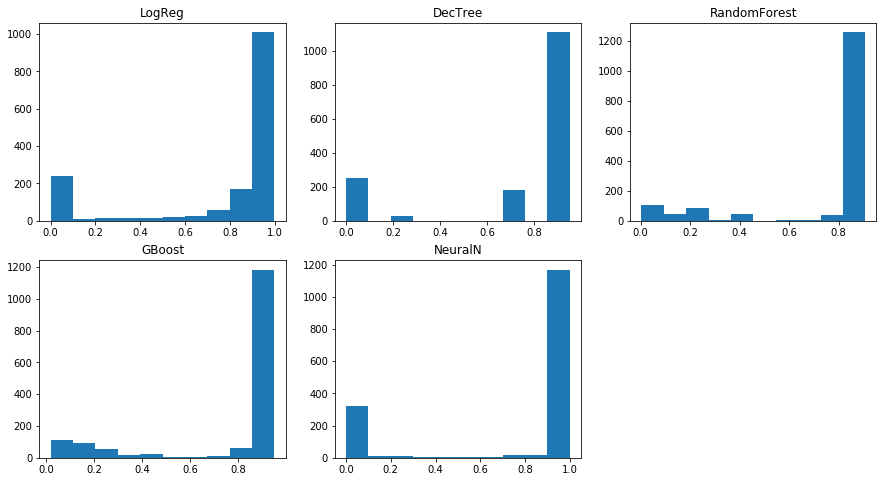

In [254]:
# Plot the probbaility distribution of all the models created:
plt.figure(figsize=(15, 8))
i = 230

for model_name, probs in zip(['LogReg', 'DecTree', 'RandomForest', 'GBoost', 'NeuralN'],
                             [lr_probs, dt_probs, rf_probs, gb_probs, nn_probs]):
    i += 1
    plt.subplot(i)
    plt.hist(probs)
    plt.title(model_name)
    
plt.show()

### 6.1 ROC auc score

In [255]:
# ROC curve for each model:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

In [256]:
pd.DataFrame({'train_ROC': [lr_auc_train, dt_auc_train, rf_auc_train, gb_auc_train, nn_auc_train],
              'test_ROC': [lr_auc, dt_auc, rf_auc, gb_auc, nn_auc]},
             index=['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network'])

,train_ROC,test_ROC
Logistic Regression,0.983375,0.981290
Decision Tree,0.912740,0.915827
Random Forest,0.925298,0.932281
Gradient Boosting,0.953934,0.956655
Neural Network,0.997789,0.998346


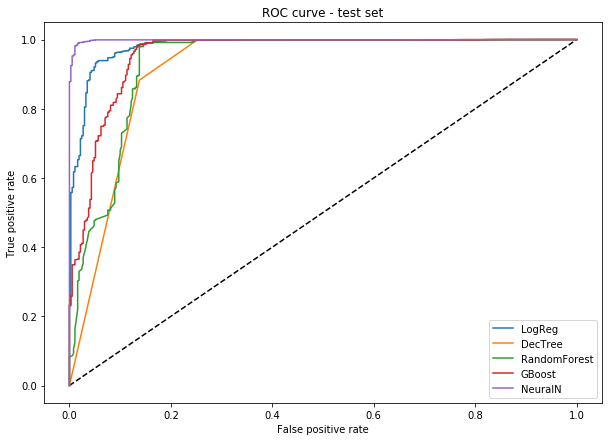

In [258]:
plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_fpr, lr_tpr, label='LogReg')
plt.plot(dt_fpr, dt_tpr, label='DecTree')
plt.plot(rf_fpr, rf_tpr, label='RandomForest')
plt.plot(gb_fpr, gb_tpr, label='GBoost')
plt.plot(nn_fpr, nn_tpr, label='NeuralN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - test set')
plt.legend(loc='best')
plt.show()

Having the auc score of every model, we can conclude that the best model is Neural network.
The ROC curve is almost at 90 degrees indicating that the model performs very well.

## 7. Model results:

### 7.1 Confusion matrix:

In [259]:
# We have already plot the confusion matrix after each model.
# Now we redo them, without using seaborn:
pd.DataFrame([['TN', 'FP'], ['FN', 'TP']],
             columns=pd.MultiIndex(levels=[['prediction'], ['0', '1']], codes=[[0, 0], [0, 1]]),
             index=pd.MultiIndex(levels=[['STATUS'], ['0', '1']], codes=[[0, 0], [0, 1]]))

prediction    
                  0   1
STATUS 0         TN  FP
       1         FN  TP

#### 7.1.1 Confusion Matrix for Logistic Regression

In [260]:
pretty_confusion_matrix(y_test, lr_preds)

prediction      
                  0     1
STATUS 0        292    78
       1          2  1199

#### 7.1.2 Confusion Matrix for Decision Tree

In [261]:
pretty_confusion_matrix(y_test, dt_preds)

prediction      
                  0     1
STATUS 0        277    93
       1          2  1199

#### 7.1.3 Confusion Matrix for Random Forest

In [262]:
pretty_confusion_matrix(y_test, rf_preds)

prediction      
                  0     1
STATUS 0        277    93
       1          1  1200

#### 7.1.4 Confusion Matrix for Gradient Boosting

In [263]:
pretty_confusion_matrix(y_test, gb_preds)

prediction      
                  0     1
STATUS 0        304    66
       1          2  1199

#### 7.1.5 Confusion Matrix for Neural Networks

In [264]:
pretty_confusion_matrix(y_test, nn_preds)

prediction      
                  0     1
STATUS 0        353    17
       1          2  1199

### 7.2  Accuracy:
It is the percentage of correctly classified records on the total.

In [265]:
accuracies = [] # percentage of the correct classified instances
for item in ['lr_preds','dt_preds','rf_preds','gb_preds','nn_preds']:
    a = accuracy_score(y_test, eval(item))
    accuracies.append(a)
    print('accuracy for {}: {}'.format(item,a))
    
# also from here I can see that neural network is the model performing better 

accuracy for lr_preds: 0.9490770210057289
accuracy for dt_preds: 0.939528962444303
accuracy for rf_preds: 0.9401654996817314
accuracy for gb_preds: 0.9567154678548695
accuracy for nn_preds: 0.9879057924888606


### 7.3  Precision - Recall:

- Precision is the percentage of true positive on all records predicted as positive
TP/ (TP+FP)
- Recall is the percentage of true positive on all observed positive records
TP/(TP+FN)

In [266]:
precisions = []
recalls = []
for item in ['lr_preds','dt_preds','rf_preds','gb_preds','nn_preds']:
    p = precision_score(y_test, eval(item))
    r = recall_score(y_test, eval(item))
    precisions.append(p)
    recalls.append(r)
    print('precision for {}: {}'.format(item,p))
    print('recall for {}: {}'.format(item,r))
    print('\n')

precision for lr_preds: 0.9389193422083008
recall for lr_preds: 0.9983347210657785


precision for dt_preds: 0.9280185758513931
recall for dt_preds: 0.9983347210657785


precision for rf_preds: 0.9280742459396751
recall for rf_preds: 0.9991673605328892


precision for gb_preds: 0.9478260869565217
recall for gb_preds: 0.9983347210657785


precision for nn_preds: 0.9860197368421053
recall for nn_preds: 0.9983347210657785




### 7.4 F-1 score:

$$ F1\:Score = \frac{2 * Precision * Recall}{Precision + Recall} $$

In [267]:
f1 = []
for item in ['lr_preds','dt_preds','rf_preds','gb_preds','nn_preds']:
    f = f1_score(y_test, eval(item))
    f1.append(f)
    print('f1-score for {}: {}'.format(item,f))

f1-score for lr_preds: 0.9677158999192899
f1-score for dt_preds: 0.9618933012434818
f1-score for rf_preds: 0.9623095429029671
f1-score for gb_preds: 0.9724249797242499
f1-score for nn_preds: 0.9921390153082333


We did our analysis using the default cut-off of 0.5. However, we can choose a cut-off value, also called threshold value. The scores above this value will classified as positive, those below as negative. 

We already have very high accuracy with the default cut-off, so it would not be necessary to change it. 
Because of the already high accuracy, we can't just choose a value as cut-off but we have to choose the best cut-off value. The optimal cut off point is where the “true positive rate” is high and the “false positive rate” is low. The optimal cut-off is the point where there is the elbow of the ROC curve (remember that the ROC curve is a distribution).

In [277]:
# let's find the optimal cut-off: 
# we consider our best model, which is Neural Network
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test,nn_probs)

In [278]:
# compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.7698501664999003

In [279]:
from sklearn.metrics import make_scorer

In [280]:
# let's set our new cut-off:
cutoff = 0.7698501664999003
def new_f1(y, probs):
    preds = [1 if x >= cutoff else 0 for x in probs]
    return f1_score(y, preds)

# let's find our new f-1 score:
new_f1_scorer = make_scorer(new_f1, greater_is_better=True, needs_proba=True)

In [281]:
from sklearn.model_selection import cross_validate

In [282]:
# cross-validation:
scores_lr = cross_validate(lr, X, Y, scoring=new_f1_scorer, cv=5)

In [283]:
print(scores_lr['test_score'], '--->', np.mean(scores_lr['test_score']))

[0.96368715 0.9650838  0.96089385 0.9707113  0.96940195] ---> 0.9659556097378441


In [284]:
for item in ['lr','dt','rf','gb','nn']:
    scores = cross_validate(eval(item), X, Y, scoring=new_f1_scorer, cv=5)
    print('test --> new f1-score for {}: {}'.format(item,np.mean(scores['test_score'])))

test --> new f1-score for lr: 0.9659556097378441
test --> new f1-score for dt: 0.9282703035560234
test --> new f1-score for rf: 0.9609104290765587
test --> new f1-score for gb: 0.9707321421628825
Iteration 1, loss = 0.57137131
Iteration 2, loss = 0.48218076
Iteration 3, loss = 0.42433058
Iteration 4, loss = 0.38540850
Iteration 5, loss = 0.35930641
Iteration 6, loss = 0.33826204
Iteration 7, loss = 0.31858067
Iteration 8, loss = 0.30144611
Iteration 9, loss = 0.28279861
Iteration 10, loss = 0.26429122
Iteration 11, loss = 0.24913044
Iteration 12, loss = 0.23485044
Iteration 13, loss = 0.22022110
Iteration 14, loss = 0.20714484
Iteration 15, loss = 0.19562688
Iteration 16, loss = 0.18393182
Iteration 17, loss = 0.17500614
Iteration 18, loss = 0.16681724
Iteration 19, loss = 0.15932751
Iteration 20, loss = 0.15300376
Iteration 21, loss = 0.14708450
Iteration 22, loss = 0.14109251
Iteration 23, loss = 0.13592627
Iteration 24, loss = 0.13102378
Iteration 25, loss = 0.12779914
Iteration 26,

In [285]:
# now that we have a new cut-off, we calculate the new probability predictions:
the_cutoff = 0.7698501664999003
new_lr_preds = [1 if x >= the_cutoff else 0 for x in lr_probs]
new_dt_preds = [1 if x >= the_cutoff else 0 for x in dt_probs]
new_rf_preds = [1 if x >= the_cutoff else 0 for x in rf_probs]
new_gb_preds = [1 if x >= the_cutoff else 0 for x in gb_probs]
new_nn_preds = [1 if x >= the_cutoff else 0 for x in nn_probs]

In [286]:
# Now let's do the confusion matrix for each models with the new prediction:
# Logistic regression confusion matrix:
pretty_confusion_matrix(y_test, new_lr_preds)

prediction      
                  0     1
STATUS 0        326    44
       1         35  1166

In [287]:
# Decision tree confusion matrix:
pretty_confusion_matrix(y_test, new_dt_preds)

prediction      
                  0     1
STATUS 0        319    51
       1        141  1060

In [288]:
# Random forest confusion matrix:
pretty_confusion_matrix(y_test, new_rf_preds)

prediction      
                  0     1
STATUS 0        279    91
       1          3  1198

In [289]:
# Gradient boosting confusion matrix:
pretty_confusion_matrix(y_test, new_gb_preds)

prediction      
                  0     1
STATUS 0        314    56
       1         14  1187

In [290]:
# Neural network confusion matrix:
pretty_confusion_matrix(y_test, new_nn_preds)

prediction      
                  0     1
STATUS 0        364     6
       1         13  1188

In [291]:
# Now let's find all the scores for each model with the new prediction:
# Logistic regression scores:
pd.DataFrame([accuracy_score(y_test, new_lr_preds), precision_score(y_test, new_lr_preds), recall_score(y_test, new_lr_preds),
              f1_score(y_test, new_lr_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.949714
Precision,0.963636
Recall,0.970858
F1-Score,0.967234


In [292]:
# Decision tree scores:
pd.DataFrame([accuracy_score(y_test, new_dt_preds), precision_score(y_test, new_dt_preds), recall_score(y_test, new_dt_preds),
              f1_score(y_test, new_dt_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.877785
Precision,0.954095
Recall,0.882598
F1-Score,0.916955


In [293]:
# Random forest scores:
pd.DataFrame([accuracy_score(y_test, new_rf_preds), precision_score(y_test, new_rf_preds), recall_score(y_test, new_rf_preds),
              f1_score(y_test, new_rf_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.940165
Precision,0.929403
Recall,0.997502
F1-Score,0.962249


In [294]:
# Gradient boosting scores:
pd.DataFrame([accuracy_score(y_test, new_gb_preds), precision_score(y_test, new_gb_preds), recall_score(y_test, new_gb_preds),
              f1_score(y_test, new_gb_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.955442
Precision,0.954948
Recall,0.988343
F1-Score,0.971358


In [295]:
# Neural network scores:
pd.DataFrame([accuracy_score(y_test, new_nn_preds), precision_score(y_test, new_nn_preds), recall_score(y_test, new_nn_preds),
              f1_score(y_test, new_nn_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.987906
Precision,0.994975
Recall,0.989176
F1-Score,0.992067


### 7.5 Esembling models:


Ensemble modeling is a process of creating a model composed by different algorithms in order to gain a better prediction of the outcome, compared to the prediction of a simple stand-alone algorithm. It could also be done by using different training data sets. 

The ensemble model then aggregates the prediction of each base model and results in one final prediction for the unseen data. 

The goal of the ensambling model is to reduce the generalization error of the prediction.

In our particular case we decided to perform an ensembled model with the algorithms we used before, but not using a different train and test splitting. We put together all the models except Decision tree, because it is the model with the smaller accuracy. However, the accuracy of Decision tree is still quite good.

In [296]:
# put together the models and it will return probability distribution
from sklearn.ensemble import VotingClassifier

In [297]:
ensemble = VotingClassifier(estimators=[('lr',lr),('rf', rf), ('gnb', gb),('nn',nn)], voting='soft')
# soft instead of using labels use probability.

In [298]:
scores = cross_validate(ensemble, X, Y, scoring=new_f1_scorer, cv=5)
print('test --> new f1-score for ensemble: {}'.format(np.mean(scores['test_score'])))

Iteration 1, loss = 0.57137131
Iteration 2, loss = 0.48218076
Iteration 3, loss = 0.42433058
Iteration 4, loss = 0.38540850
Iteration 5, loss = 0.35930641
Iteration 6, loss = 0.33826204
Iteration 7, loss = 0.31858067
Iteration 8, loss = 0.30144611
Iteration 9, loss = 0.28279861
Iteration 10, loss = 0.26429122
Iteration 11, loss = 0.24913044
Iteration 12, loss = 0.23485044
Iteration 13, loss = 0.22022110
Iteration 14, loss = 0.20714484
Iteration 15, loss = 0.19562688
Iteration 16, loss = 0.18393182
Iteration 17, loss = 0.17500614
Iteration 18, loss = 0.16681724
Iteration 19, loss = 0.15932751
Iteration 20, loss = 0.15300376
Iteration 21, loss = 0.14708450
Iteration 22, loss = 0.14109251
Iteration 23, loss = 0.13592627
Iteration 24, loss = 0.13102378
Iteration 25, loss = 0.12779914
Iteration 26, loss = 0.12370593
Iteration 27, loss = 0.12050507
Iteration 28, loss = 0.11771647
Iteration 29, loss = 0.11422637
Iteration 30, loss = 0.11268660
Iteration 31, loss = 0.10962412
Iteration 32, los

In [299]:
ensemble.fit(X,Y)

Iteration 1, loss = 0.55523192
Iteration 2, loss = 0.45557387
Iteration 3, loss = 0.39757931
Iteration 4, loss = 0.36097638
Iteration 5, loss = 0.33474930
Iteration 6, loss = 0.31076206
Iteration 7, loss = 0.28902523
Iteration 8, loss = 0.26665242
Iteration 9, loss = 0.24576626
Iteration 10, loss = 0.22801252
Iteration 11, loss = 0.21117334
Iteration 12, loss = 0.19605708
Iteration 13, loss = 0.18228206
Iteration 14, loss = 0.17063531
Iteration 15, loss = 0.16083218
Iteration 16, loss = 0.15192362
Iteration 17, loss = 0.14473336
Iteration 18, loss = 0.13814282
Iteration 19, loss = 0.13203344
Iteration 20, loss = 0.12667169
Iteration 21, loss = 0.12247295
Iteration 22, loss = 0.11839315
Iteration 23, loss = 0.11450536
Iteration 24, loss = 0.11117913
Iteration 25, loss = 0.10899579
Iteration 26, loss = 0.10617996
Iteration 27, loss = 0.10337841
Iteration 28, loss = 0.10151462
Iteration 29, loss = 0.09970281
Iteration 30, loss = 0.09761978
Iteration 31, loss = 0.09620639
Iteration 32, los

VotingClassifier(estimators=[('lr',
                              Pipeline(memory=None,
                                       steps=[('scaler',
                                               RobustScaler(copy=True,
                                                            quantile_range=(25.0,
                                                                            75.0),
                                                            with_centering=True,
                                                            with_scaling=True)),
                                              ('model',
                                               LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_sca

In [300]:
# Compute probability prediction:
ensemble_preds = ensemble.predict(X_test)
# Let's compare the results obtained (prediction on train and test):
ensemble_probs_train = [y for (x, y) in ensemble.predict_proba(X)]
ensemble_probs = [y for (x, y) in ensemble.predict_proba(X_test)]

# Compute all the scores for the esembling models:
ensemble_auc_train = roc_auc_score(Y, ensemble_probs_train)
ensemble_auc = roc_auc_score(y_test, ensemble_probs)
ensemble_f1_train = f1_score(Y, ensemble.predict(X))
ensemble_f1 = f1_score(y_test, ensemble_preds)
ensemble_precision_train = precision_score(Y, ensemble.predict(X))
ensemble_precision = precision_score(y_test, ensemble_preds)
ensemble_recall_train = recall_score(Y, ensemble.predict(X))
ensemble_recall = recall_score(y_test, ensemble_preds)

# Print the results:
print('train auc: {}'.format(ensemble_auc_train))
print('test auc: {}'.format(ensemble_auc))
print('train f1: {}'.format(ensemble_f1_train))
print('test f1: {}'.format(ensemble_f1))
print('train recall: {}'.format(ensemble_recall_train))
print('test recall: {}'.format(ensemble_recall))
print('train precision: {}'.format(ensemble_precision_train))
print('test precision: {}'.format(ensemble_precision))

train auc: 0.9970112493842719
test auc: 0.9964286517991763
train f1: 0.974129757551131
test f1: 0.9771986970684039
train recall: 0.9980571745767416
test recall: 0.9991673605328892
train precision: 0.9513227513227513
test precision: 0.9561752988047809


In [301]:
# put all the results together:
final_results = {}
for model in ['lr','dt','rf','gb','nn','ensemble']:
    m = eval(model)
    if model == 'lr':
        preds= m.predict(X)
        pred_probs = [x[1] for x in m.predict_proba(X)]
        
        preds_test = m.predict(X_test)
        pred_probs_test = [x[1] for x in m.predict_proba(X_test)]
    else:
        preds= m.predict(X)
        pred_probs = [x[1] for x in m.predict_proba(X)]
        
        preds_test= m.predict(X_test)
        pred_probs_test = [x[1] for x in  m.predict_proba(X_test)] 
        
    final_results[model] = {}
    # auc test
    final_results[model].update({'auc_test' : roc_auc_score(y_test, pred_probs_test)})
    # auc train
    final_results[model].update({'auc_train' : roc_auc_score(Y, pred_probs)})
    # f1 test
    final_results[model].update({'f1_test' : f1_score(y_test, preds_test)})
    # f1 train
    final_results[model].update({'f1_train' : f1_score(Y, preds)})
    # precision test
    final_results[model].update({'precision_test' : precision_score(y_test, preds_test)})
    # precision train
    final_results[model].update({'precision_train' : precision_score(Y, preds)})
    # recall test
    final_results[model].update({'recall_test' : recall_score(y_test, preds_test)})
    # recall train
    final_results[model].update({'recall_train' : recall_score(Y, preds)})

In [302]:
# Create a dataframe with the results:
pd.DataFrame(final_results).T

,auc_test,auc_train,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
lr,0.981290,0.983375,0.967716,0.965536,0.938919,0.937516,0.998335,0.995282
dt,0.915827,0.912740,0.961893,0.958450,0.928019,0.924008,0.998335,0.995559
rf,0.932281,0.925298,0.962310,0.959840,0.928074,0.924203,0.999167,0.998335
gb,0.956655,0.953934,0.972425,0.971629,0.947826,0.946565,0.998335,0.998057
nn,0.998346,0.997789,0.992139,0.990765,0.986020,0.984118,0.998335,0.997502
ensemble,0.996429,0.997011,0.977199,0.974130,0.956175,0.951323,0.999167,0.998057


After a careful evaluation of all the models we can say, with no doubts, that the Neural Network performs much better on our type of data. 
The decision Tree initially was not performing well but it was improved by the random forest algorithm and gradient boosting. The logistic regression, as we see from the metrics of evaluation of the models, performed well, but not as well as the Neural Network. 

With the ensemble model we did not gain an improvement in the prediction with respect to the neural network and we feel free to say that, in our case, the neural network is the best choice for the classification problem we were dealing with.



## 8. Conclusion:

In this project the goal was to find the best model to predict whether an employee would leave the company. Our target variable was the status of an employee, which can be either active or not active. Than we analysed the relationships between our target variable and other variables such as where the employee works, the age, the length of service, the job title, the store name and so on. 

The best model for the prediction of the employee churn is **Neural Network**. This could be really helpful to firms in order to predict if an employee will resign or not and it could bring to the firms money saving and time saving.